# Set Up

In [72]:
!pip install scanpy scipy umap-learn leidenalg

In [73]:
!pip install git+https://github.com/pcahan1/PySingleCellNet/

  Cloning https://github.com/pcahan1/PySingleCellNet/ to /tmp/pip-req-build-_ch4kw71
  Running command git clone --filter=blob:none --quiet https://github.com/pcahan1/PySingleCellNet/ /tmp/pip-req-build-_ch4kw71
  Resolved https://github.com/pcahan1/PySingleCellNet/ to commit c7647dec06ed8fc2ca48237acc5ec4e221aeab7e
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.0 MB/s eta 0:00:00
  Created wheel for pySingleCellNet: filename=pySingleCellNet-0.1-py3-none-any.whl size=35874 sha256=115a31e035bdb333f2f410807e5c219e182fafa26759e4d22be4b12ce4900351
  Stored in directory: /tmp/pip-ephem-wheel-cache-fdifcqwq/wheels/76/5d/55/7bce388bb3d235449ac696e2b81a58004c009e6a3fc1869ec3
Successfully built pySingleCellNet


In [74]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import anndata as ad
import pySingleCellNet as pySCN
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/gdrive/')
plt.rcParams['figure.dpi'] = 300
sc.logging.print_header()

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.25.2 scipy==1.11.4 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11


In [85]:
adTrain = sc.read_h5ad("gdrive/MyDrive/Colab Notebooks/adTrain_n110_CSCB_HW2.h5ad")
adValid = sc.read_h5ad("gdrive/MyDrive/Colab Notebooks/adValidation_n300_CSCB_HW2.h5ad")
adQuery = sc.read_h5ad("gdrive/MyDrive/Colab Notebooks/adQuery_n2000_CSCB_HW2.h5ad")
marker_genes_dict = {
    'Acinar': ['REG1A'],
    'Ductal': ['MMP7', 'KRT19'],
    'Alpha': ['GCG', 'TTR', 'HIGD1A'],
    'Beta': ['INS', 'IAPP', "G6PC2"],
    'Delta': ['SST', 'RBP4', 'LEPR'],
    'Gamma': ['PPY', 'ID2', "GCNT3"],
    'Episilon': ["GHRL", "NNMT", "APOH"],
    'Macrophage': ['IFI30', 'LAPTM5'],
    'Stellate': ['COL1A2', 'COL6A2'],
}

# Question 1

## Cluster-Then-Annotate

In [86]:
adValid1 = adValid.copy()

### Preprocessing

In [87]:
sc.pp.normalize_total(adValid1, target_sum=1e4)
sc.pp.log1p(adValid1)
sc.pp.highly_variable_genes(adValid1, min_mean=0.0125, max_mean=6, min_disp=0.25)
sc.tl.pca(adValid1, use_highly_variable=True)

In [88]:
adPrep = adValid1.copy()

### Clustering

<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

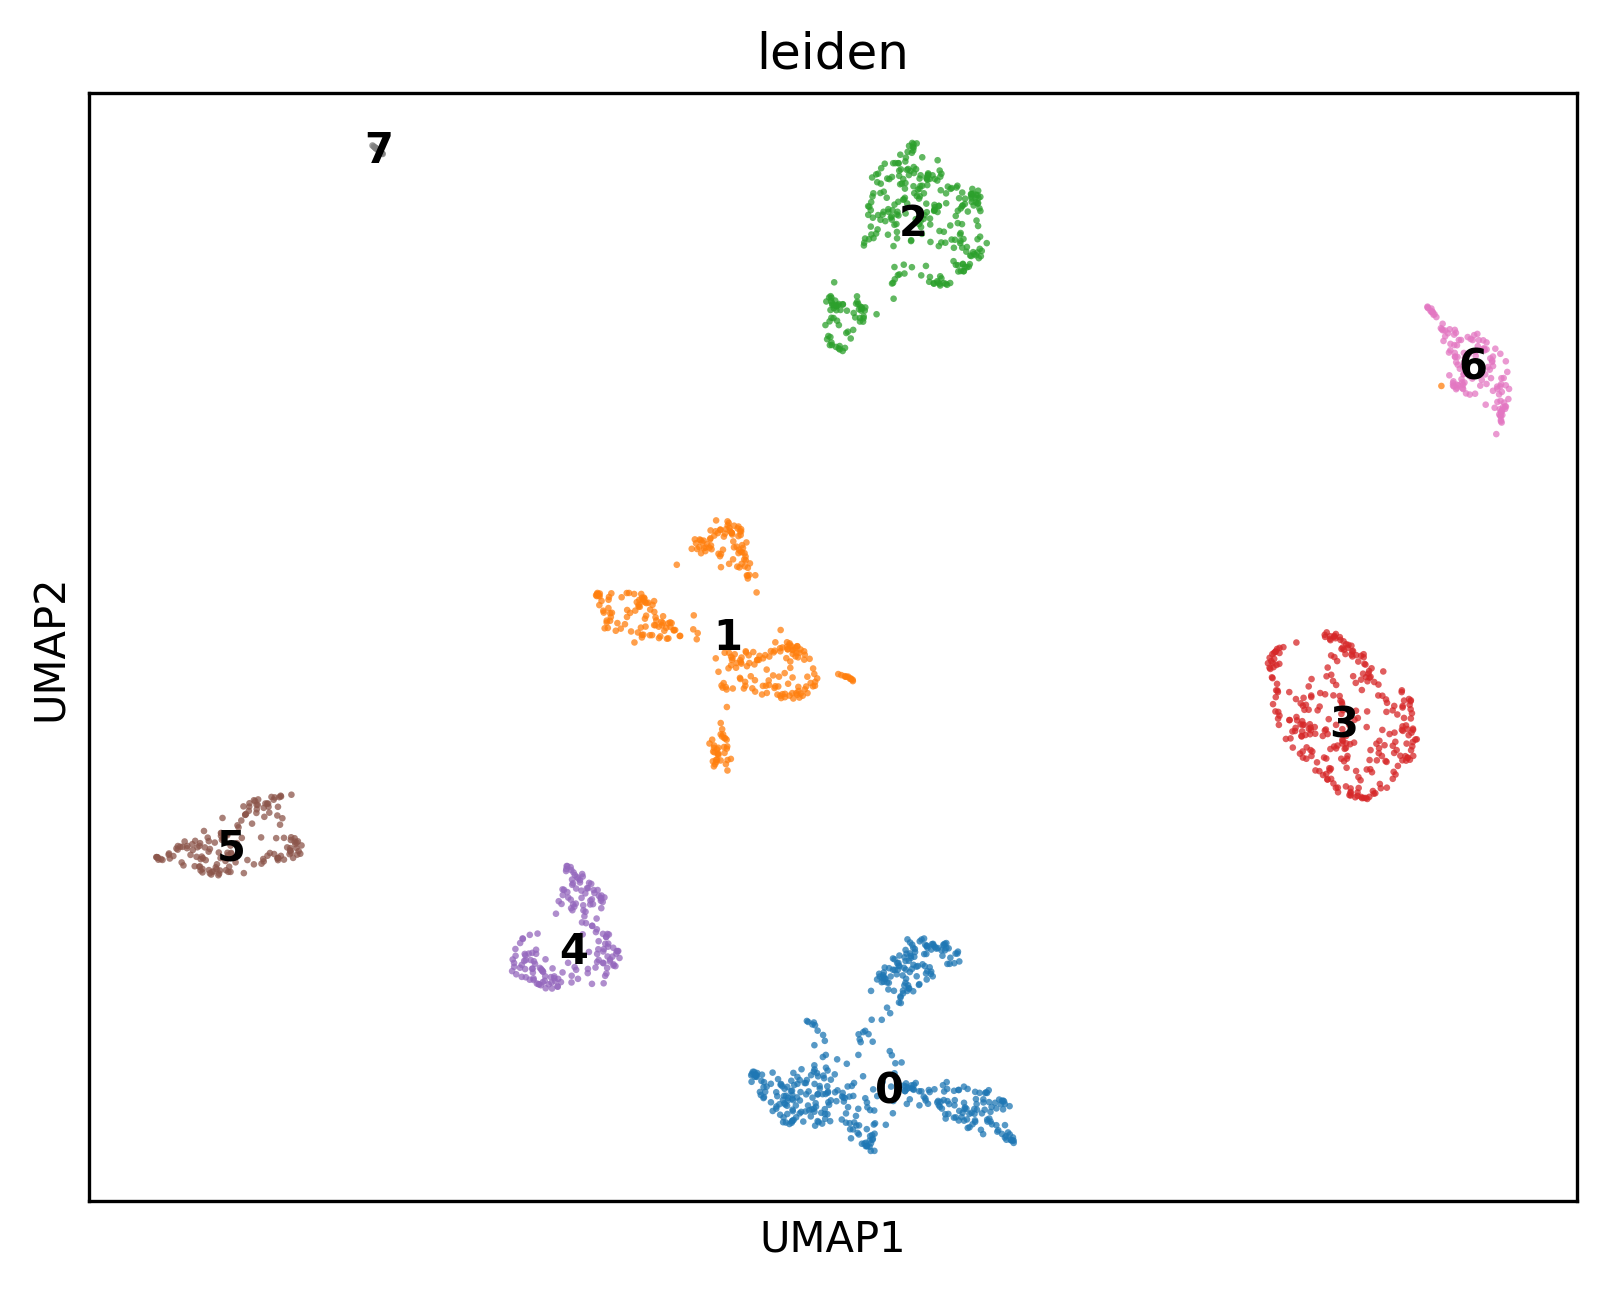

In [89]:
sc.pp.neighbors(adPrep, n_neighbors=15, n_pcs=10)
sc.tl.leiden(adPrep,.1)
sc.tl.paga(adPrep)
sc.pl.paga(adPrep, plot=False)
sc.tl.umap(adPrep, 0.25, init_pos='paga')
sc.pl.umap(adPrep,color=['leiden'], alpha=.75, s=10, legend_loc='on data', show=False)

categories: 0, 1, 2, etc.
var_group_labels: Acinar, Ductal, Alpha, etc.


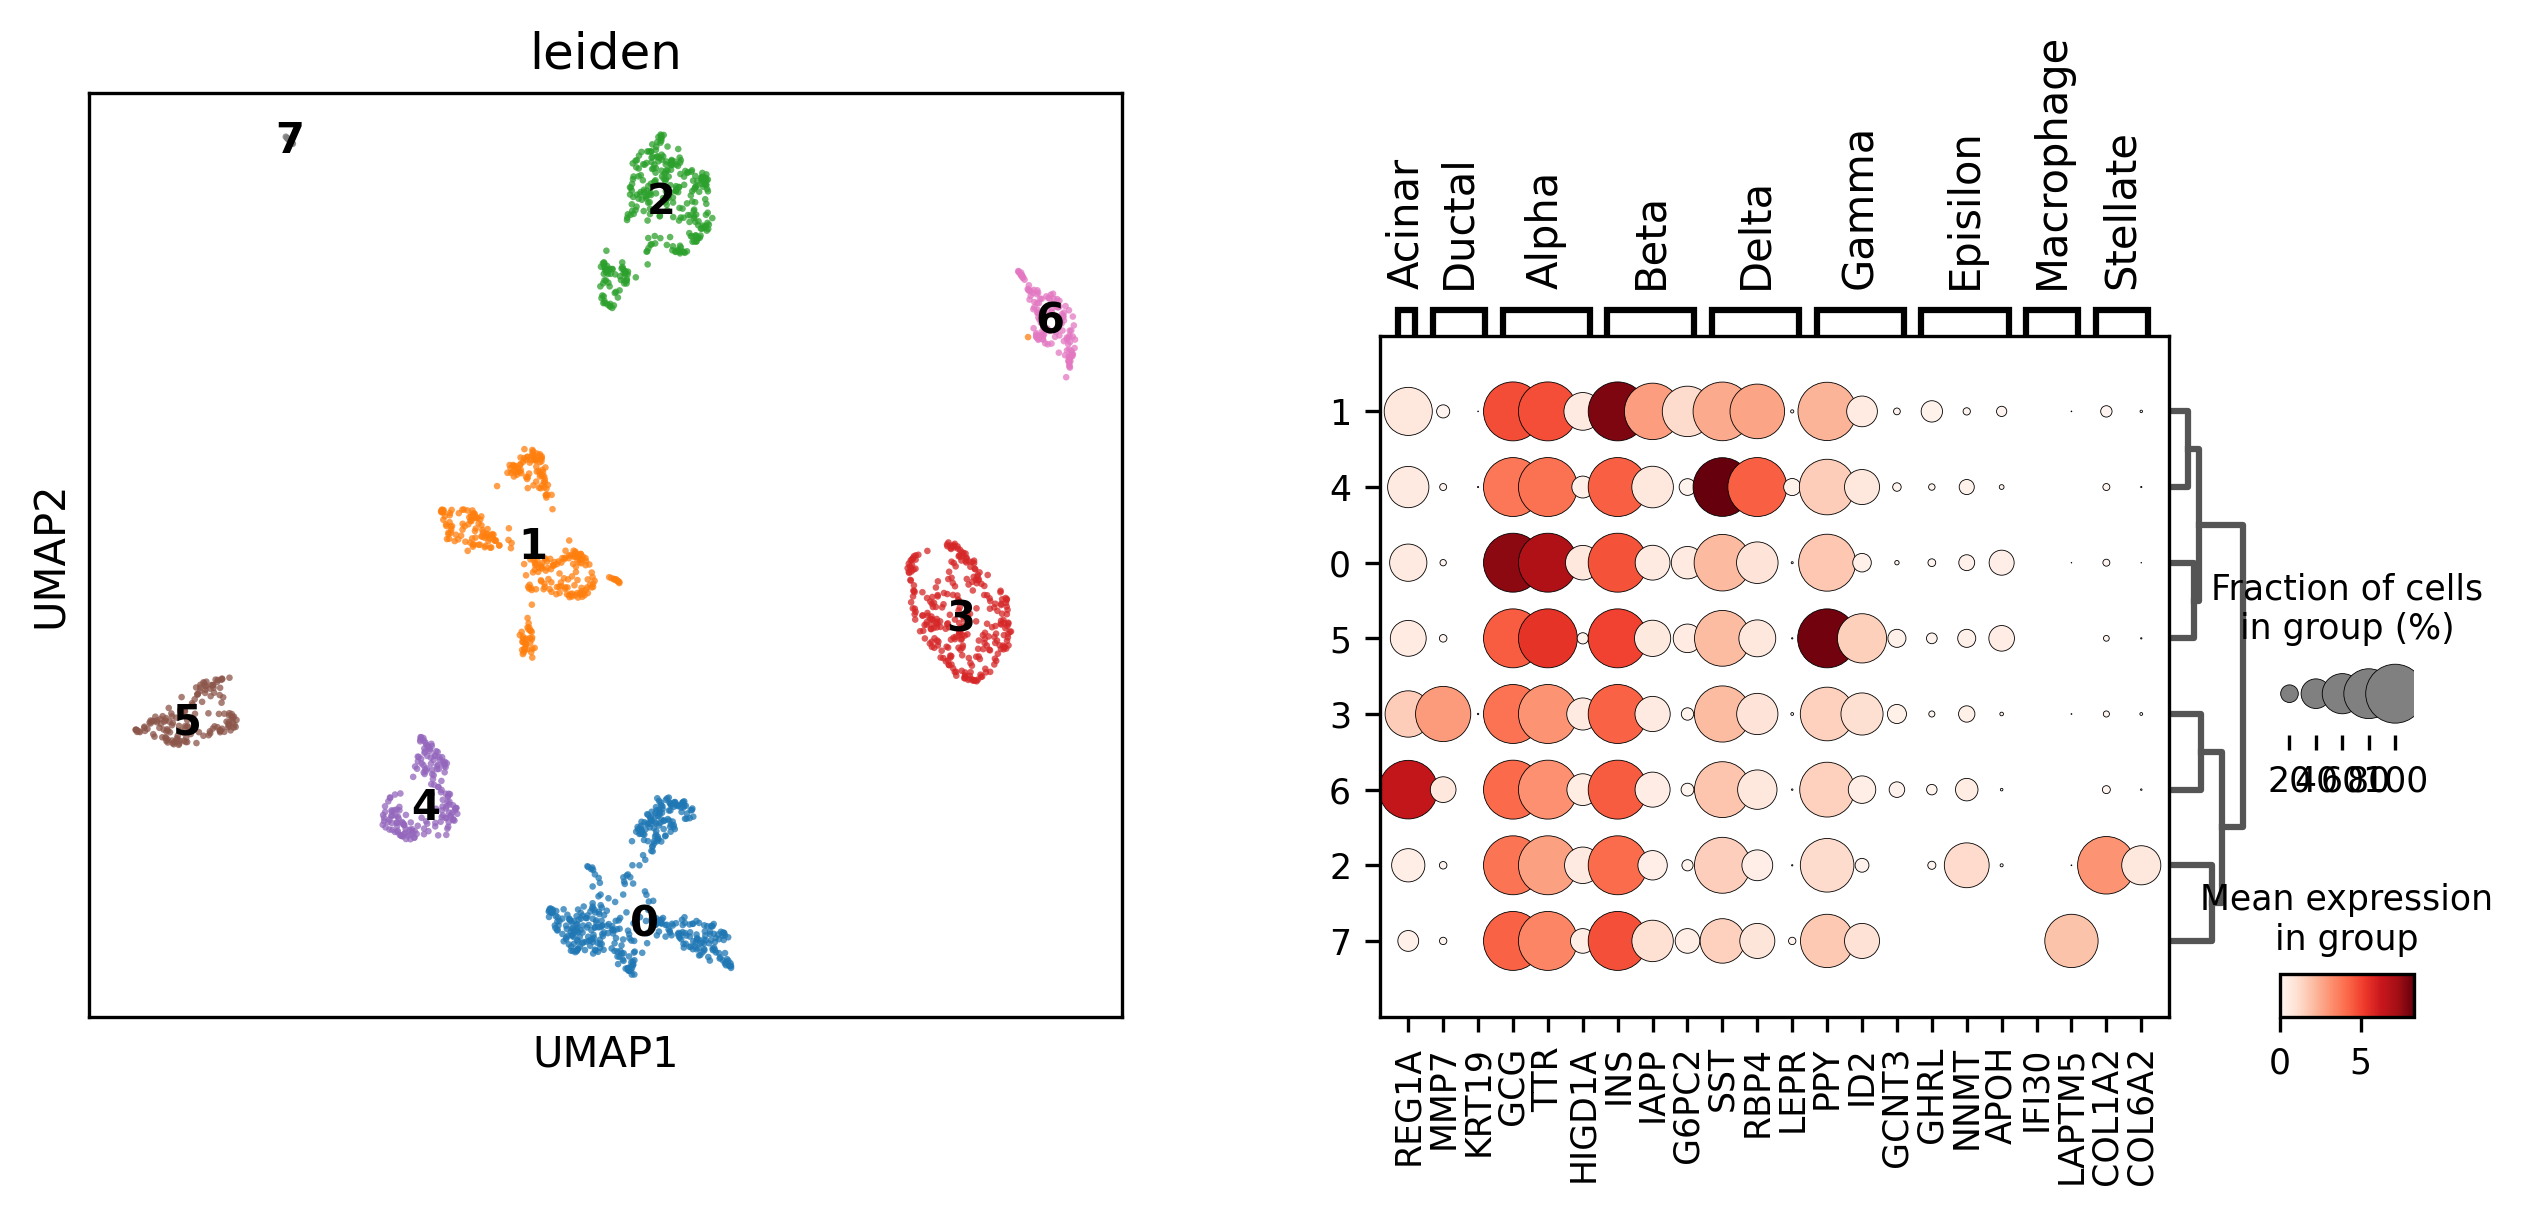

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'wspace':0.25})
ax1_dict = sc.pl.umap(adPrep,color=['leiden'], alpha=.75, s=10, legend_loc='on data', ax=ax1, show=False)
ax2_dict = sc.pl.dotplot(adPrep, marker_genes_dict, 'leiden', dendrogram=True,ax=ax2, show=False)
plt.show()

| cluster | markers  of          | cell type       |
|---------|----------------------|-----------------|
| 5       |  Gamma               | Gamma           |
| 1       | Beta                 | Beta            |
| 4       | Delta                | Delta           |
| 3       | Ductal               | Ductal          |
| 6       | Acinar               | Acinar          |
| 7       | Macrophage           | Macrophage      |
| 0       | Alpha                | Alpha           |
| 2       | Stellate/Epsilon     | ???             |

In [91]:
adCluster0 = adPrep.copy()

### Subclusters

categories: 0, 1, 2,0, etc.
var_group_labels: Acinar, Ductal, Alpha, etc.


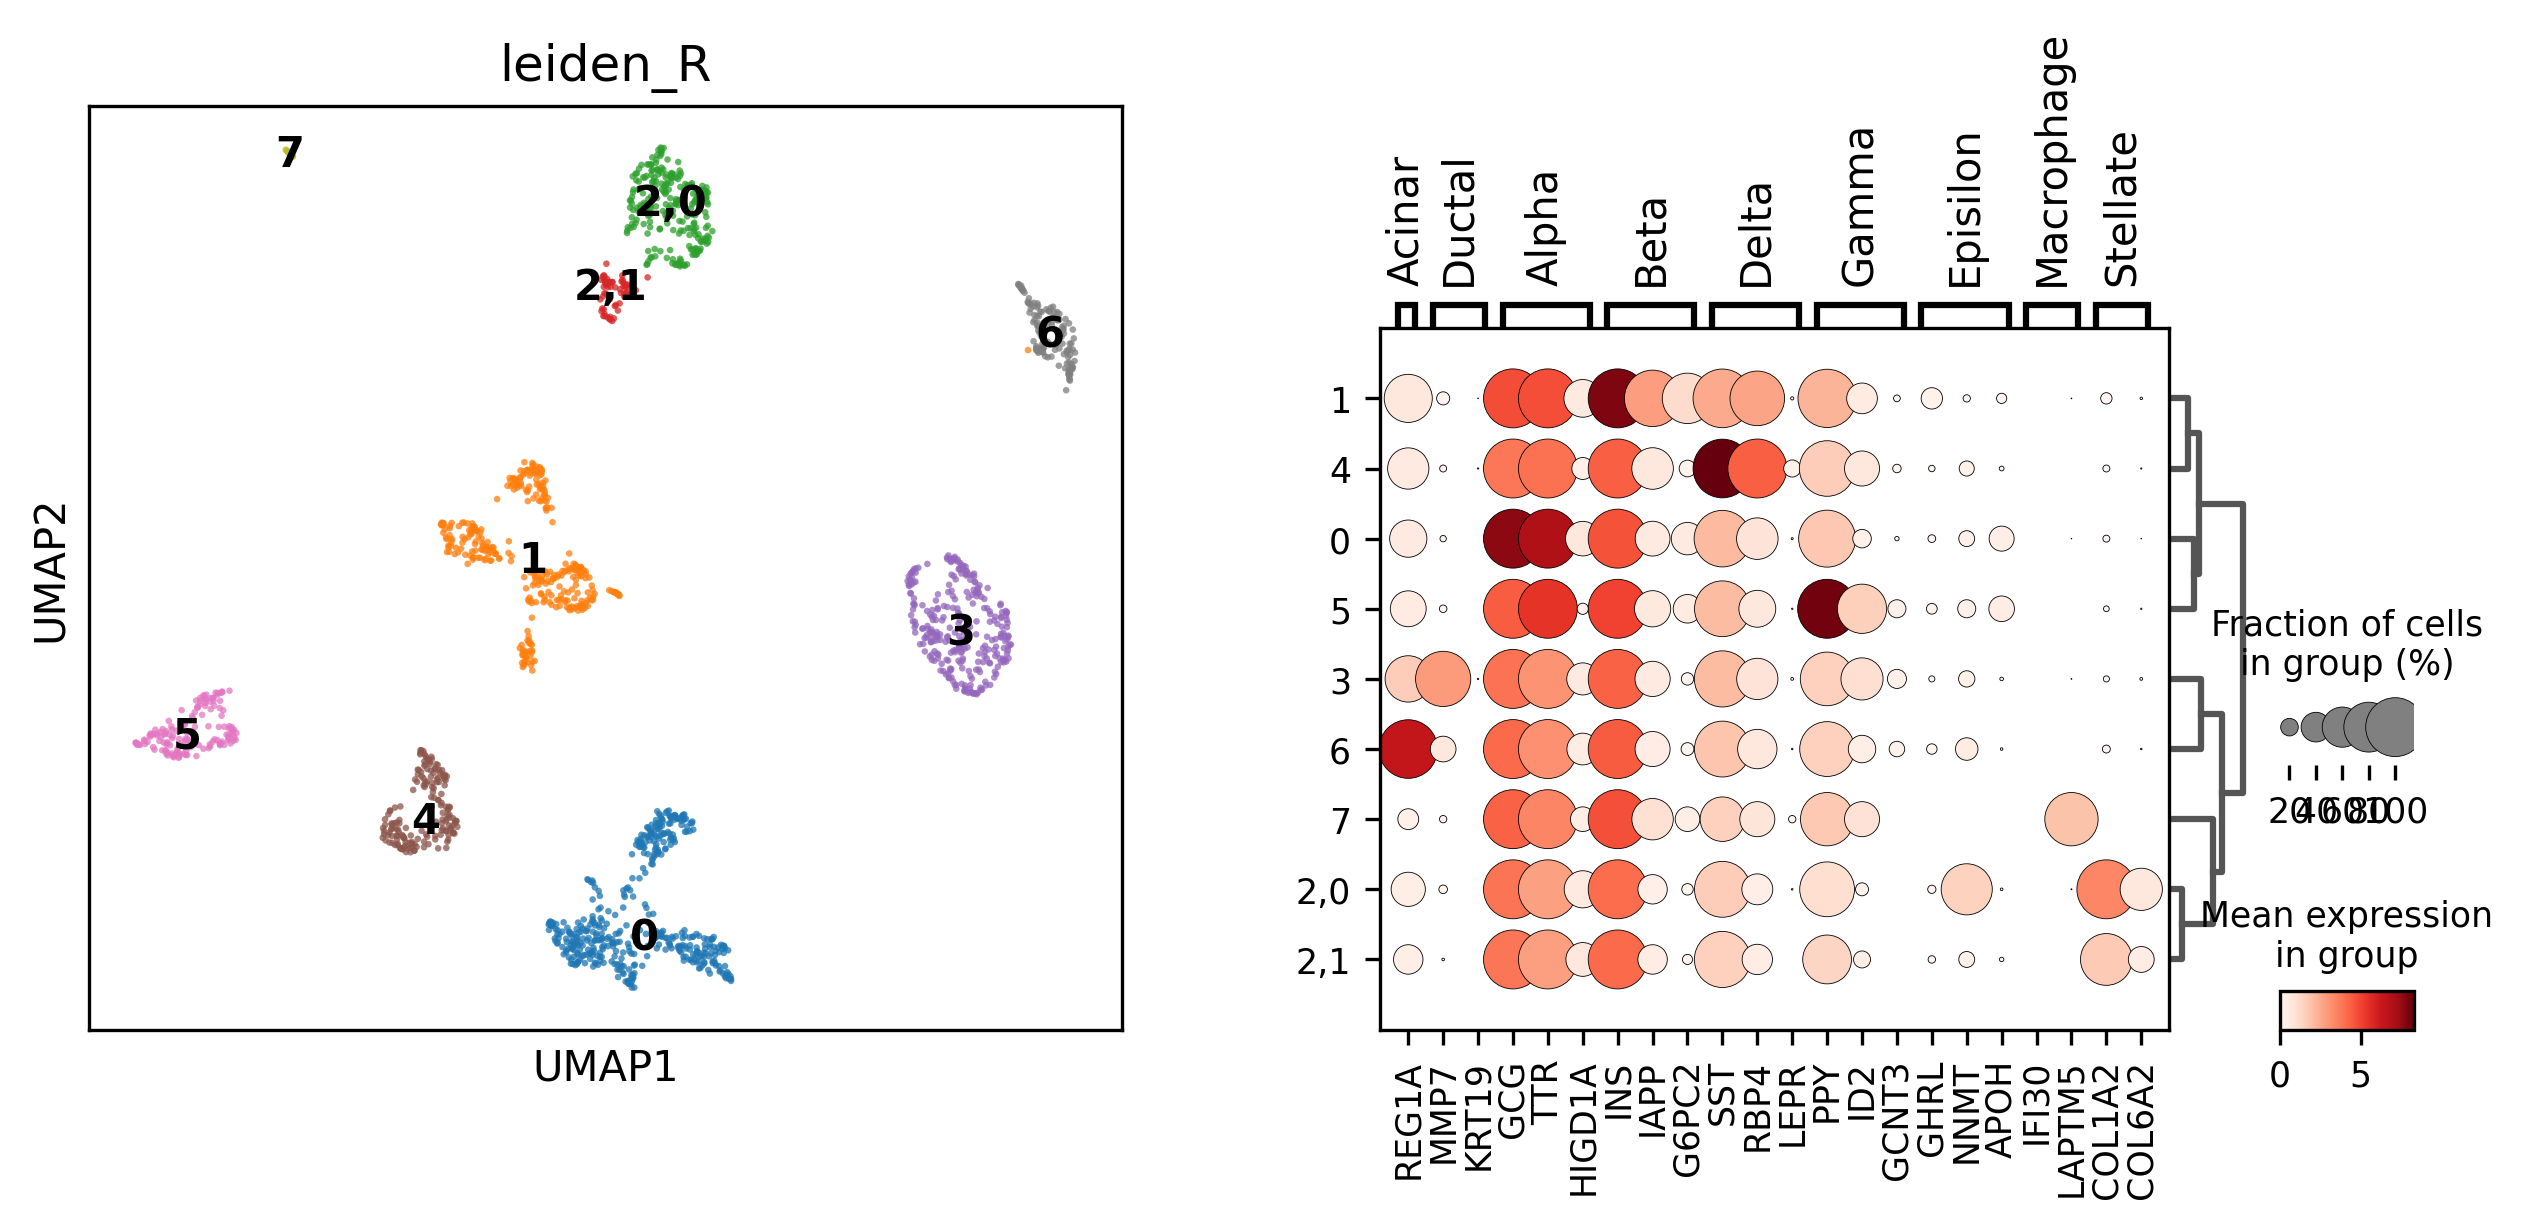

In [92]:
sc.tl.leiden(adCluster0,.1, restrict_to=["leiden",["2"]])
sc.tl.dendrogram(adCluster0, "leiden_R")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'wspace':0.25})
ax1_dict = sc.pl.umap(adCluster0,color=['leiden_R'], alpha=.75, s=10, legend_loc='on data', ax=ax1, show=False)
ax2_dict = sc.pl.dotplot(adCluster0, marker_genes_dict, 'leiden_R', dendrogram=True,ax=ax2, show=False)
plt.show()

2,0 seems to be Epsilon while 2,1 seems to be Stellate.

| cluster | markers  of          | cell type       |
|---------|----------------------|-----------------|
| 5       |  Gamma               | Gamma           |
| 1       | Beta                 | Beta            |
| 4       | Delta                | Delta           |
| 3       | Ductal               | Ductal          |
| 6       | Acinar               | Acinar          |
| 7       | Macrophage           | Macrophage      |
| 0       | Alpha                | Alpha           |
| 2,0     | Epsilon              | Epsilon         |
| 2,1     | Stellate             | Stellate        |



In [93]:
adAnn = adCluster0.copy()

### Annotating

In [94]:
cell_dict = {
    'Alpha': ['0'],                 #
    'Beta': ['1'],                  #
    'Delta': ['4'],                 #
    'Ductal': ['3'],                #
    'Stellate': ['2,1'],            #
    'Epsilon': ['2,0'],             #
    'Acinar': ['6'],                #
    'Gamma': ['5'],                 #
    'Macrophage': ['7'],            #
}

adAnn.obs['cell_type_pred'] = np.nan

for i in cell_dict.keys():
    ind = pd.Series(adAnn.obs.leiden_R).isin(cell_dict[i])
    adAnn.obs.loc[ind,'cell_type_pred'] = i

adAnn.obs['cell_type_pred'] = adAnn.obs['cell_type_pred'].astype("category")
adAnn.obs['cell_type_pred']

AAACATTGATCACG-1        Acinar
AAACGCTGGCTGTA-1    Macrophage
AAACGGCTTCGTTT-1         Gamma
AAAGGCCTATAAGG-1        Ductal
AAATCTGATTTGGG-1       Epsilon
                       ...    
TTGAGGACAGTCAC-1        Ductal
TTGGAGTGCATGAC-1          Beta
TTTAGGCTTTTCAC-1         Delta
TTTATCCTGTTGCA-1         Alpha
TTTCAGTGTTTCGT-1          Beta
Name: cell_type_pred, Length: 1861, dtype: category
Categories (9, object): ['Acinar', 'Alpha', 'Beta', 'Delta', ..., 'Epsilon', 'Gamma', 'Macrophage',
                         'Stellate']

### Performance Metrics

In [97]:
labels = np.unique(adAnn.obs['cell_type'])
scores_manual = f1_score(adAnn.obs['cell_type'], adAnn.obs['cell_type_pred'], labels = labels, average = None)
for i, label in enumerate(labels):
  print(f'{label}: {scores_manual[i]:.02f}')

Acinar: 0.96
Alpha: 0.78
Beta: 0.88
Delta: 0.72
Ductal: 0.98
Epsilon: 0.00
Gamma: 0.60
Macrophage: 0.97
Stellate: 0.28


## BKKNN


In [98]:
adValid2 = adValid.copy()

### Preprocessing

In [99]:
sc.pp.normalize_total(adValid2, target_sum=1e4)
sc.pp.log1p(adValid2)
sc.pp.highly_variable_genes(adValid2, min_mean=0.0125, max_mean=6, min_disp=0.25)
sc.tl.pca(adValid2, use_highly_variable=True)

In [100]:
adPrep = adValid2.copy()

### Clustering

In [101]:
!pip install bbknn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552448 sha256=25b05291d9538022b1dc4003bbf0a3260443e1fee53127a7da157d23d660de16
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


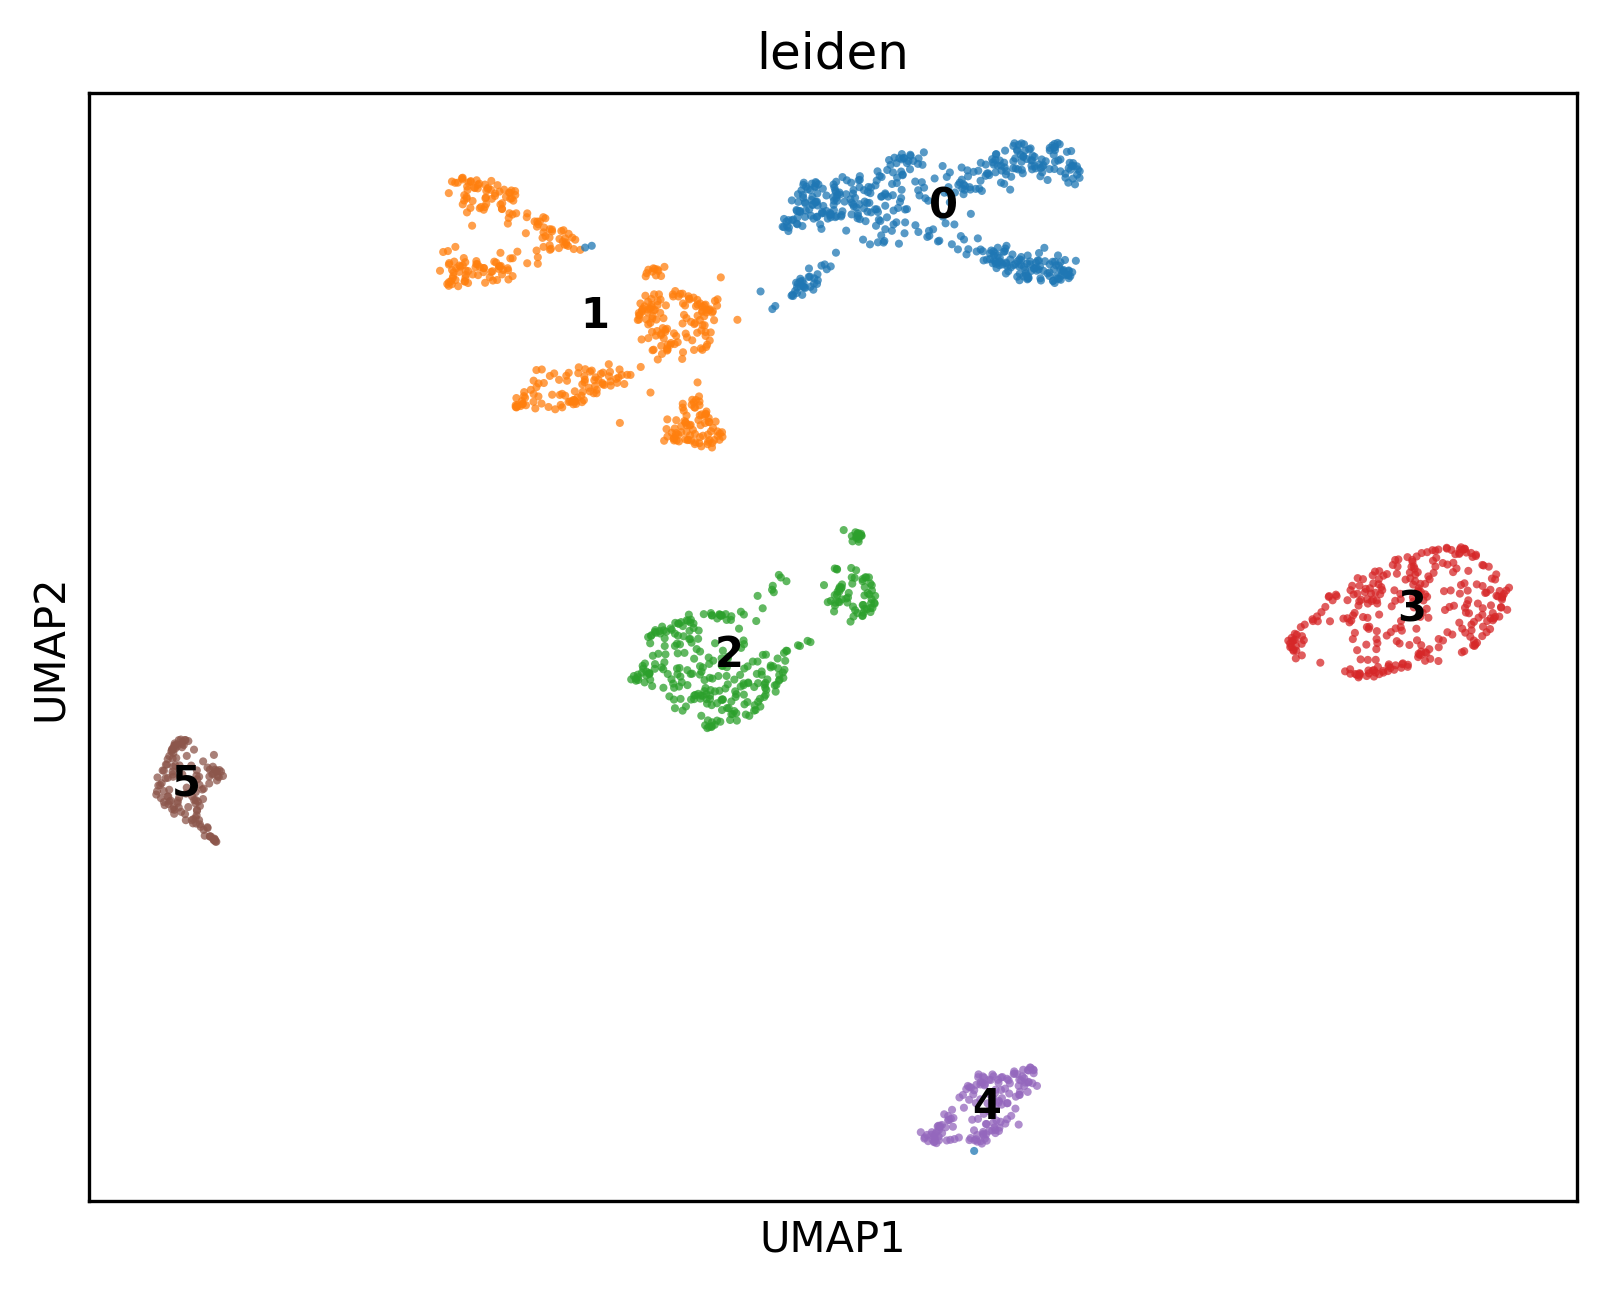

In [102]:
sc.external.pp.bbknn(adPrep, batch_key = 'sample_id', neighbors_within_batch=15, n_pcs=10)
sc.tl.leiden(adPrep,.1)
sc.tl.paga(adPrep)
sc.pl.paga(adPrep, plot=False)
sc.tl.umap(adPrep, 0.25, init_pos='paga')
sc.pl.umap(adPrep, color=['leiden'], alpha=.75, s=15, legend_loc='on data')

categories: 0, 1, 2, etc.
var_group_labels: Acinar, Ductal, Alpha, etc.


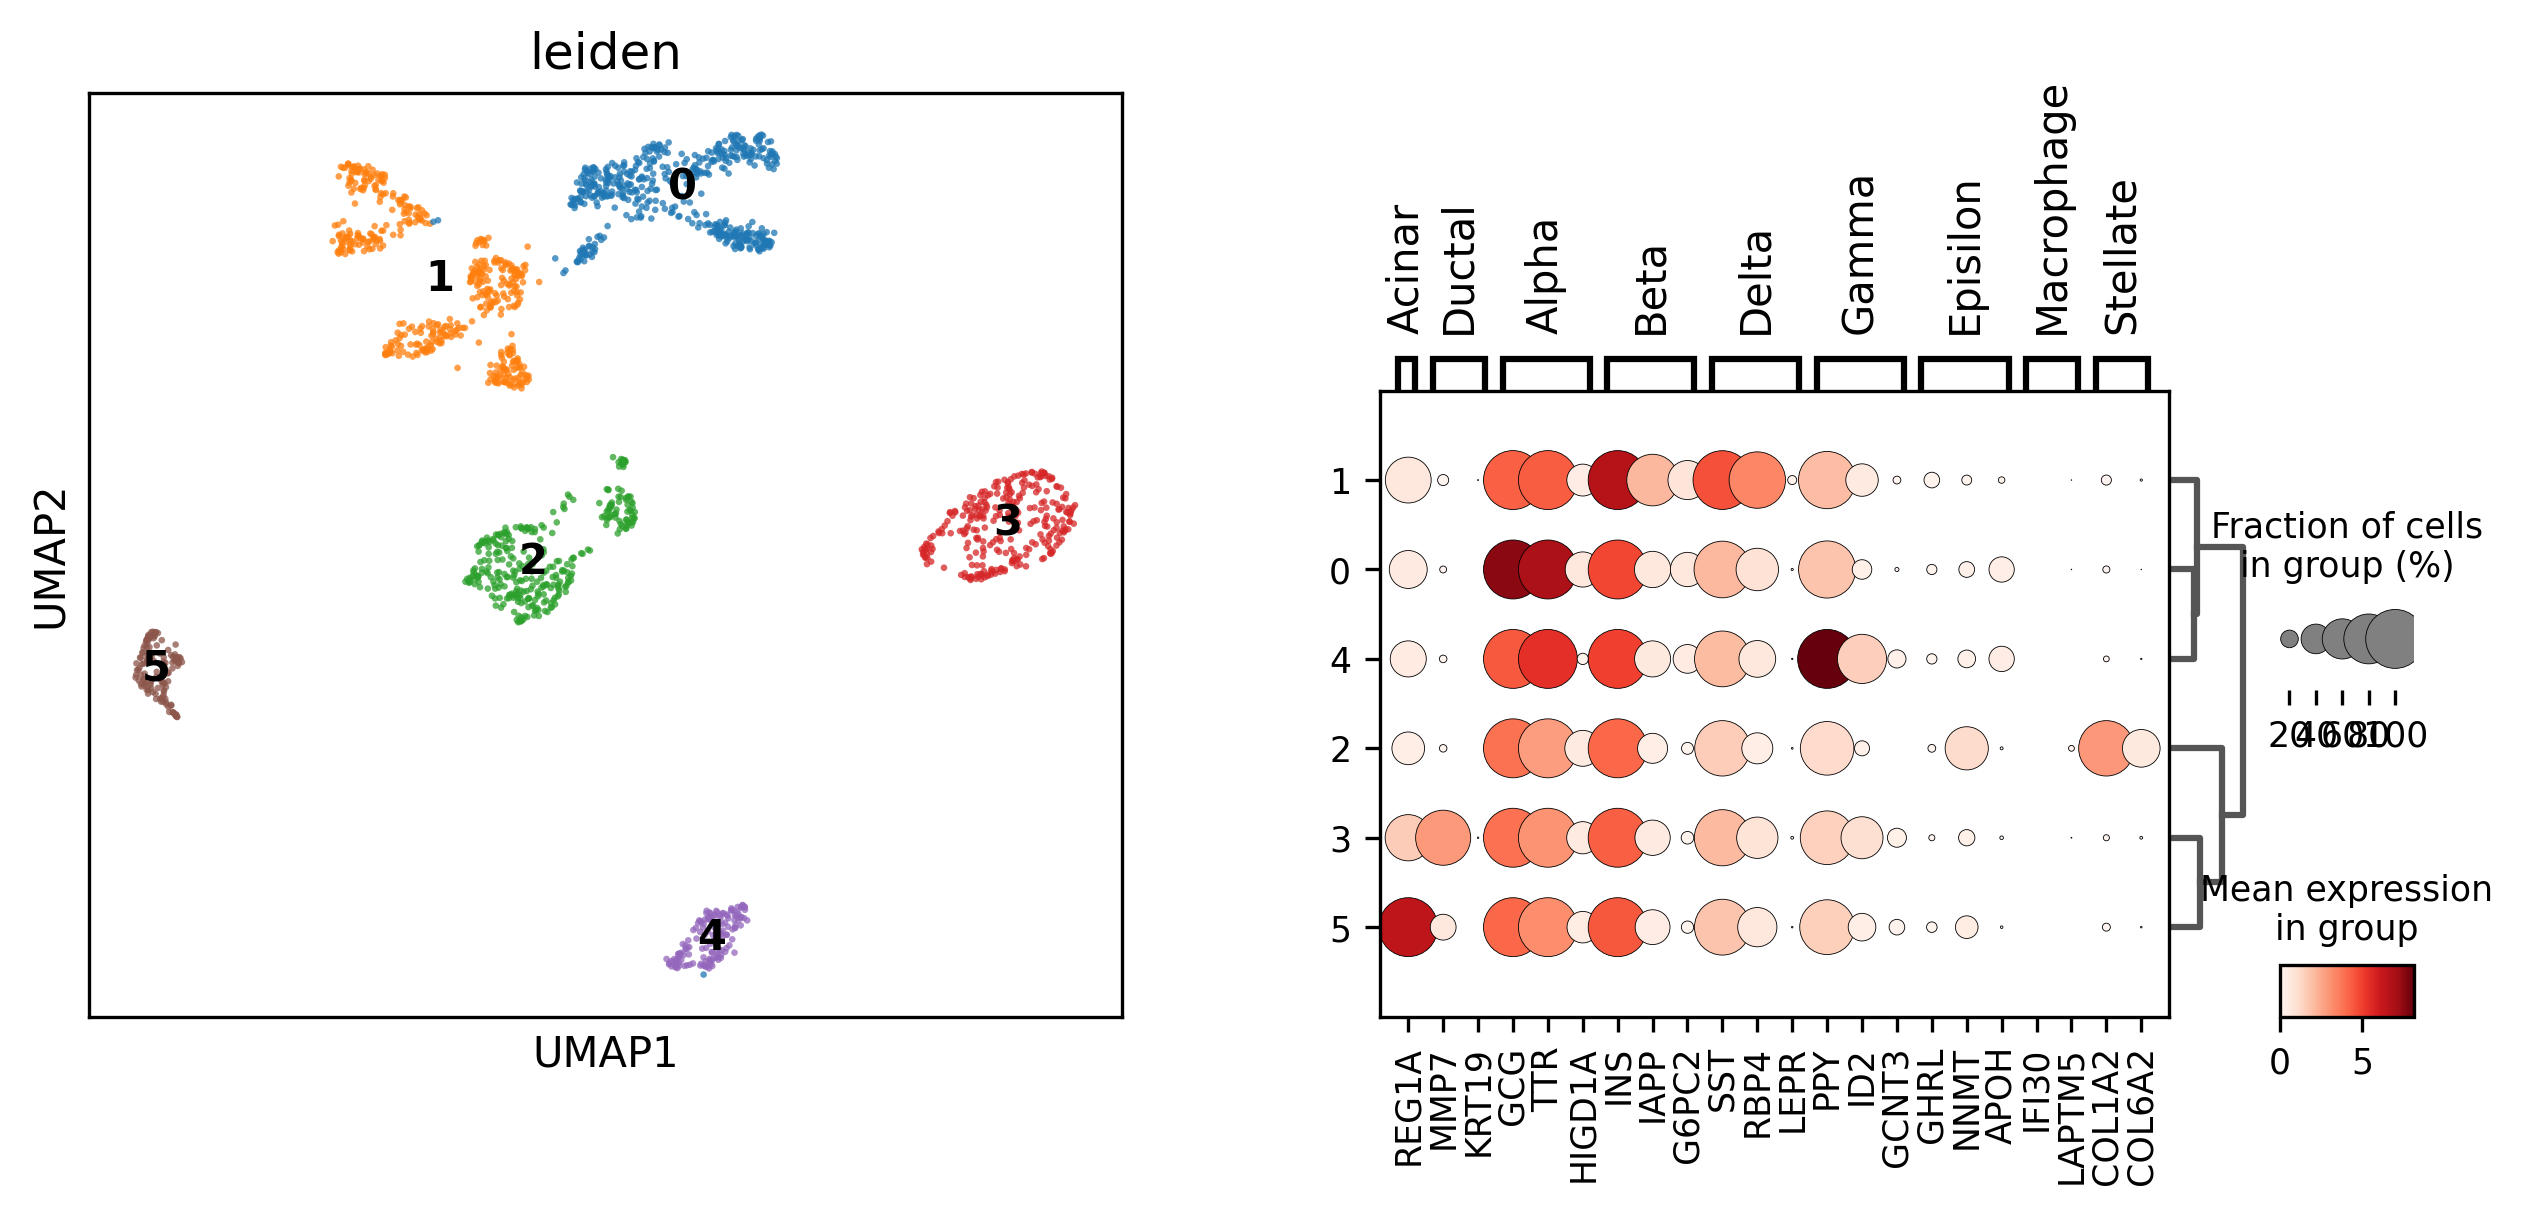

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'wspace':0.25})
ax1_dict = sc.pl.umap(adPrep,color=['leiden'], alpha=.75, s=10, legend_loc='on data', ax=ax1, show=False)
ax2_dict = sc.pl.dotplot(adPrep, marker_genes_dict, 'leiden', dendrogram=True,ax=ax2, show=False)
plt.show()

| cluster | markers  of          | cell type       |
|---------|----------------------|-----------------|
| 5       | Acinar               | Acinar          |
| 1       | Beta/Delta           | ???             |
| 4       | Gamma                | Gamma           |
| 3       | Ductal               | Ductal          |
| 0       | Alpha                | Alpha           |
| 2       | Stellate/Epsilon     | ???             |

Macrophage expression seems to be nonexistent from this viewing of the data.

In [104]:
adCluster0 = adPrep.copy()

### Subclusters

categories: 0, 1,0, 1,1, etc.
var_group_labels: Acinar, Ductal, Alpha, etc.


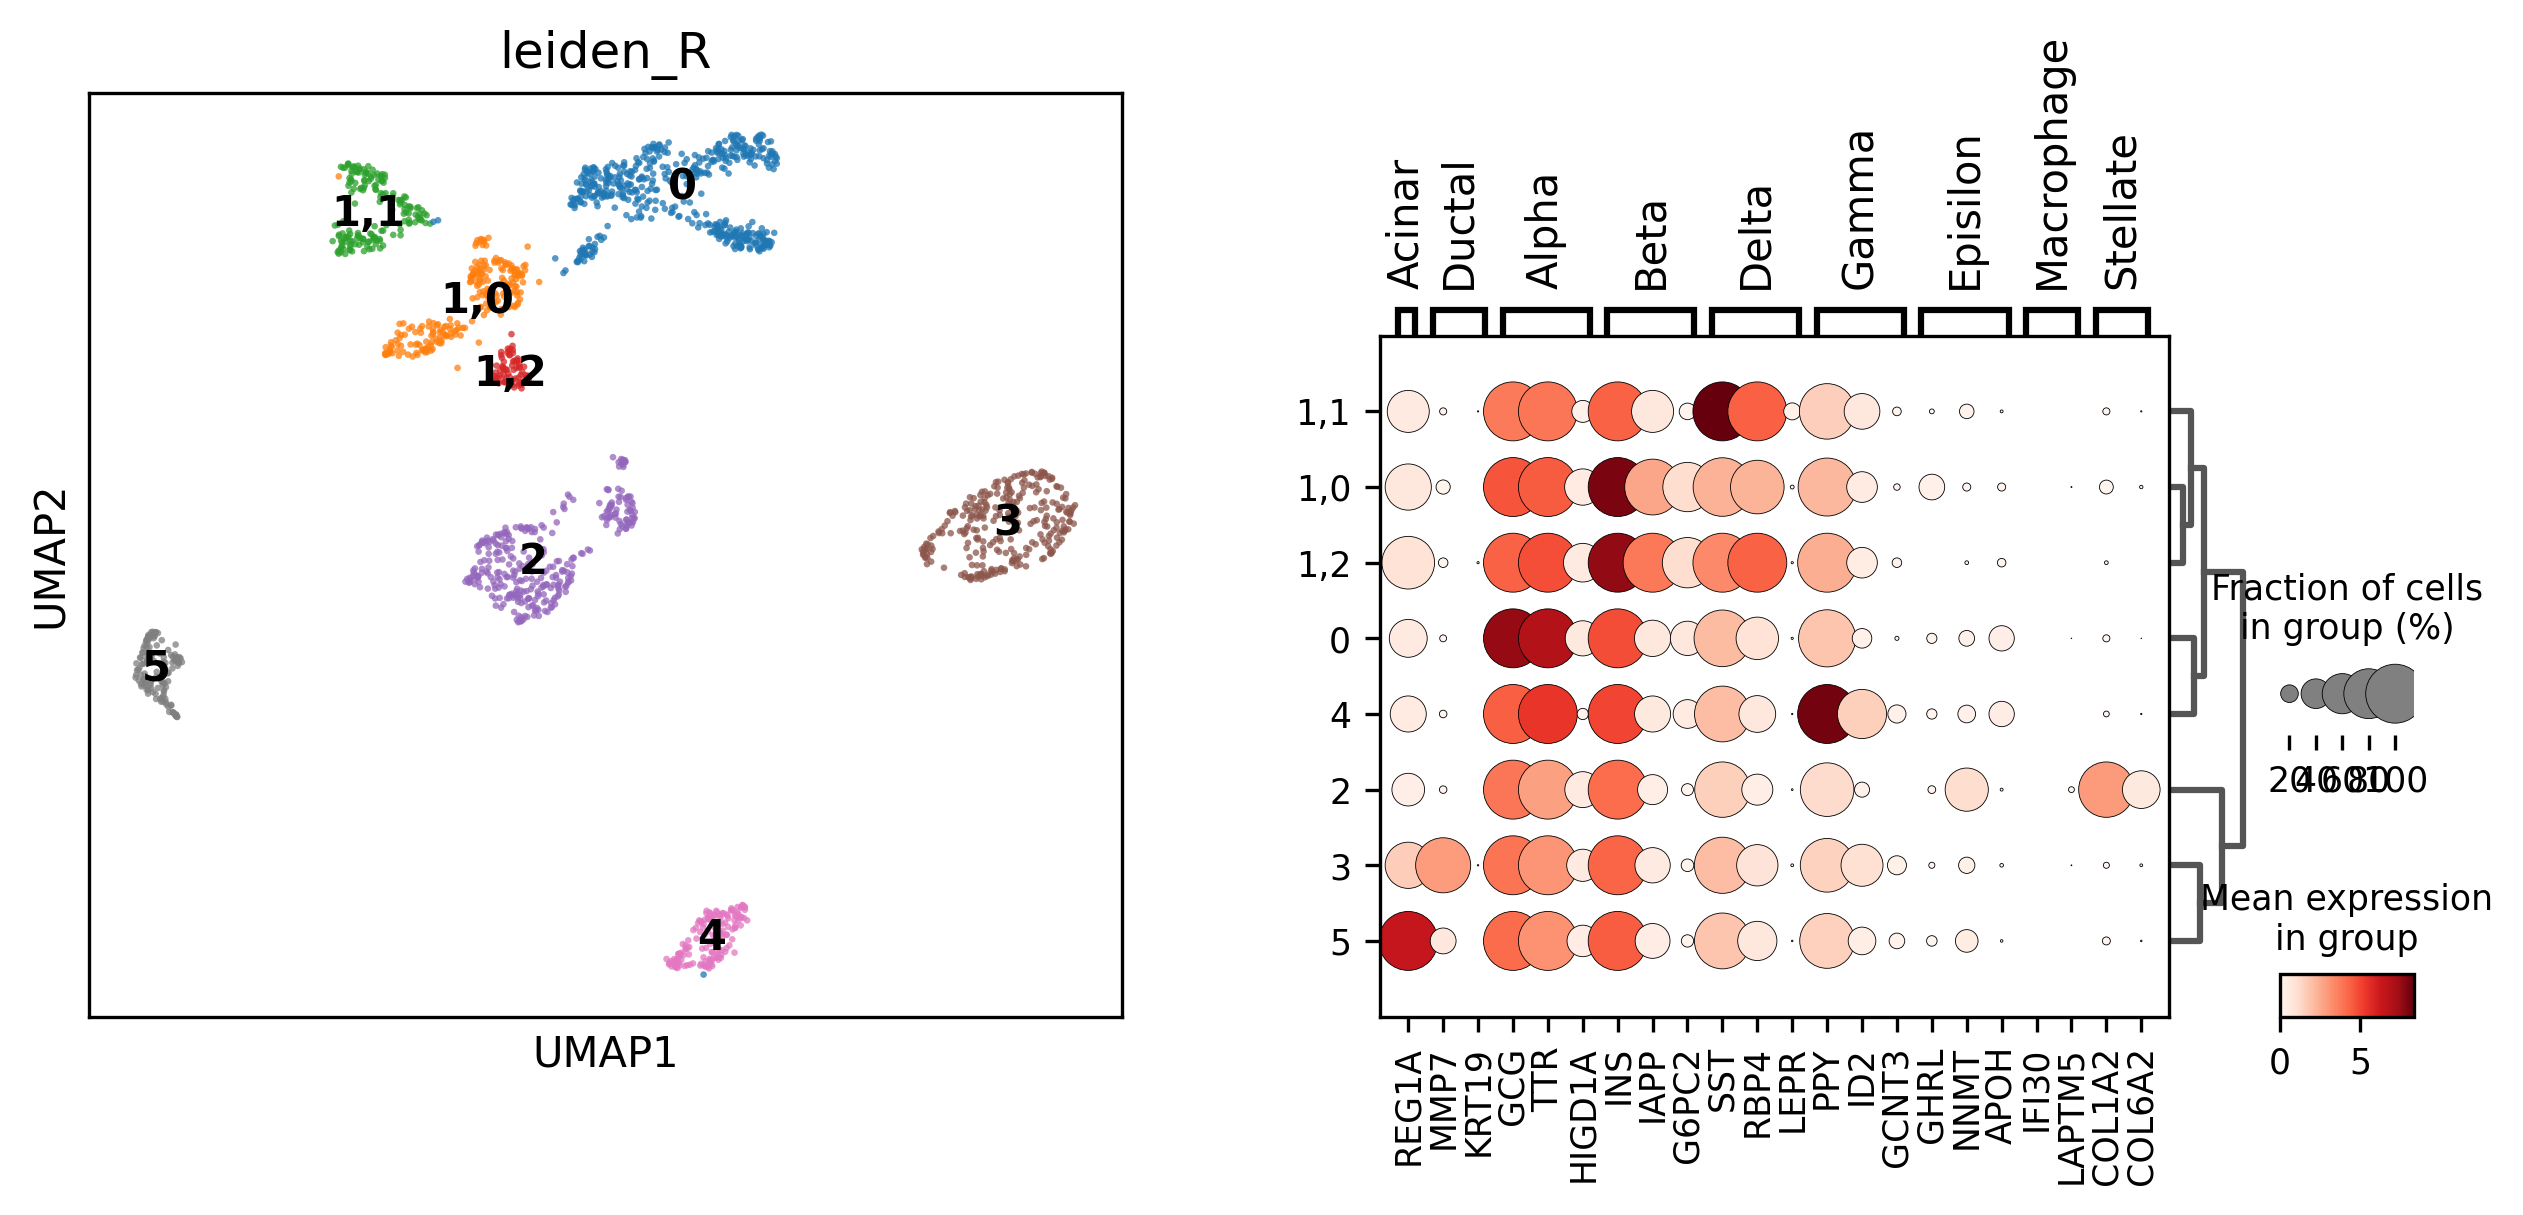

In [105]:
sc.tl.leiden(adCluster0,.1, restrict_to=["leiden",["1"]])
sc.tl.dendrogram(adCluster0, "leiden_R")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'wspace':0.25})
ax1_dict = sc.pl.umap(adCluster0,color=['leiden_R'], alpha=.75, s=10, legend_loc='on data', ax=ax1, show=False)
ax2_dict = sc.pl.dotplot(adCluster0, marker_genes_dict, 'leiden_R', dendrogram=True,ax=ax2, show=False)
plt.show()

1,1 seems to be Delta while 1,0 & 1,2 seem to be Beta.

| cluster | markers  of          | cell type       |
|---------|----------------------|-----------------|
| 4       | Gamma                | Gamma           |
| 1,0/1,2 | Beta                 | Beta            |
| 1,1     | Delta                | Delta           |
| 3       | Ductal               | Ductal          |
| 5       | Acinar               | Acinar          |
| 0       | Alpha                | Alpha           |
| 2       | Stellate/Epsilon     | ???             |

In [106]:
adCluster1 = adCluster0.copy()

categories: 0, 1,0, 1,1, etc.
var_group_labels: Acinar, Ductal, Alpha, etc.


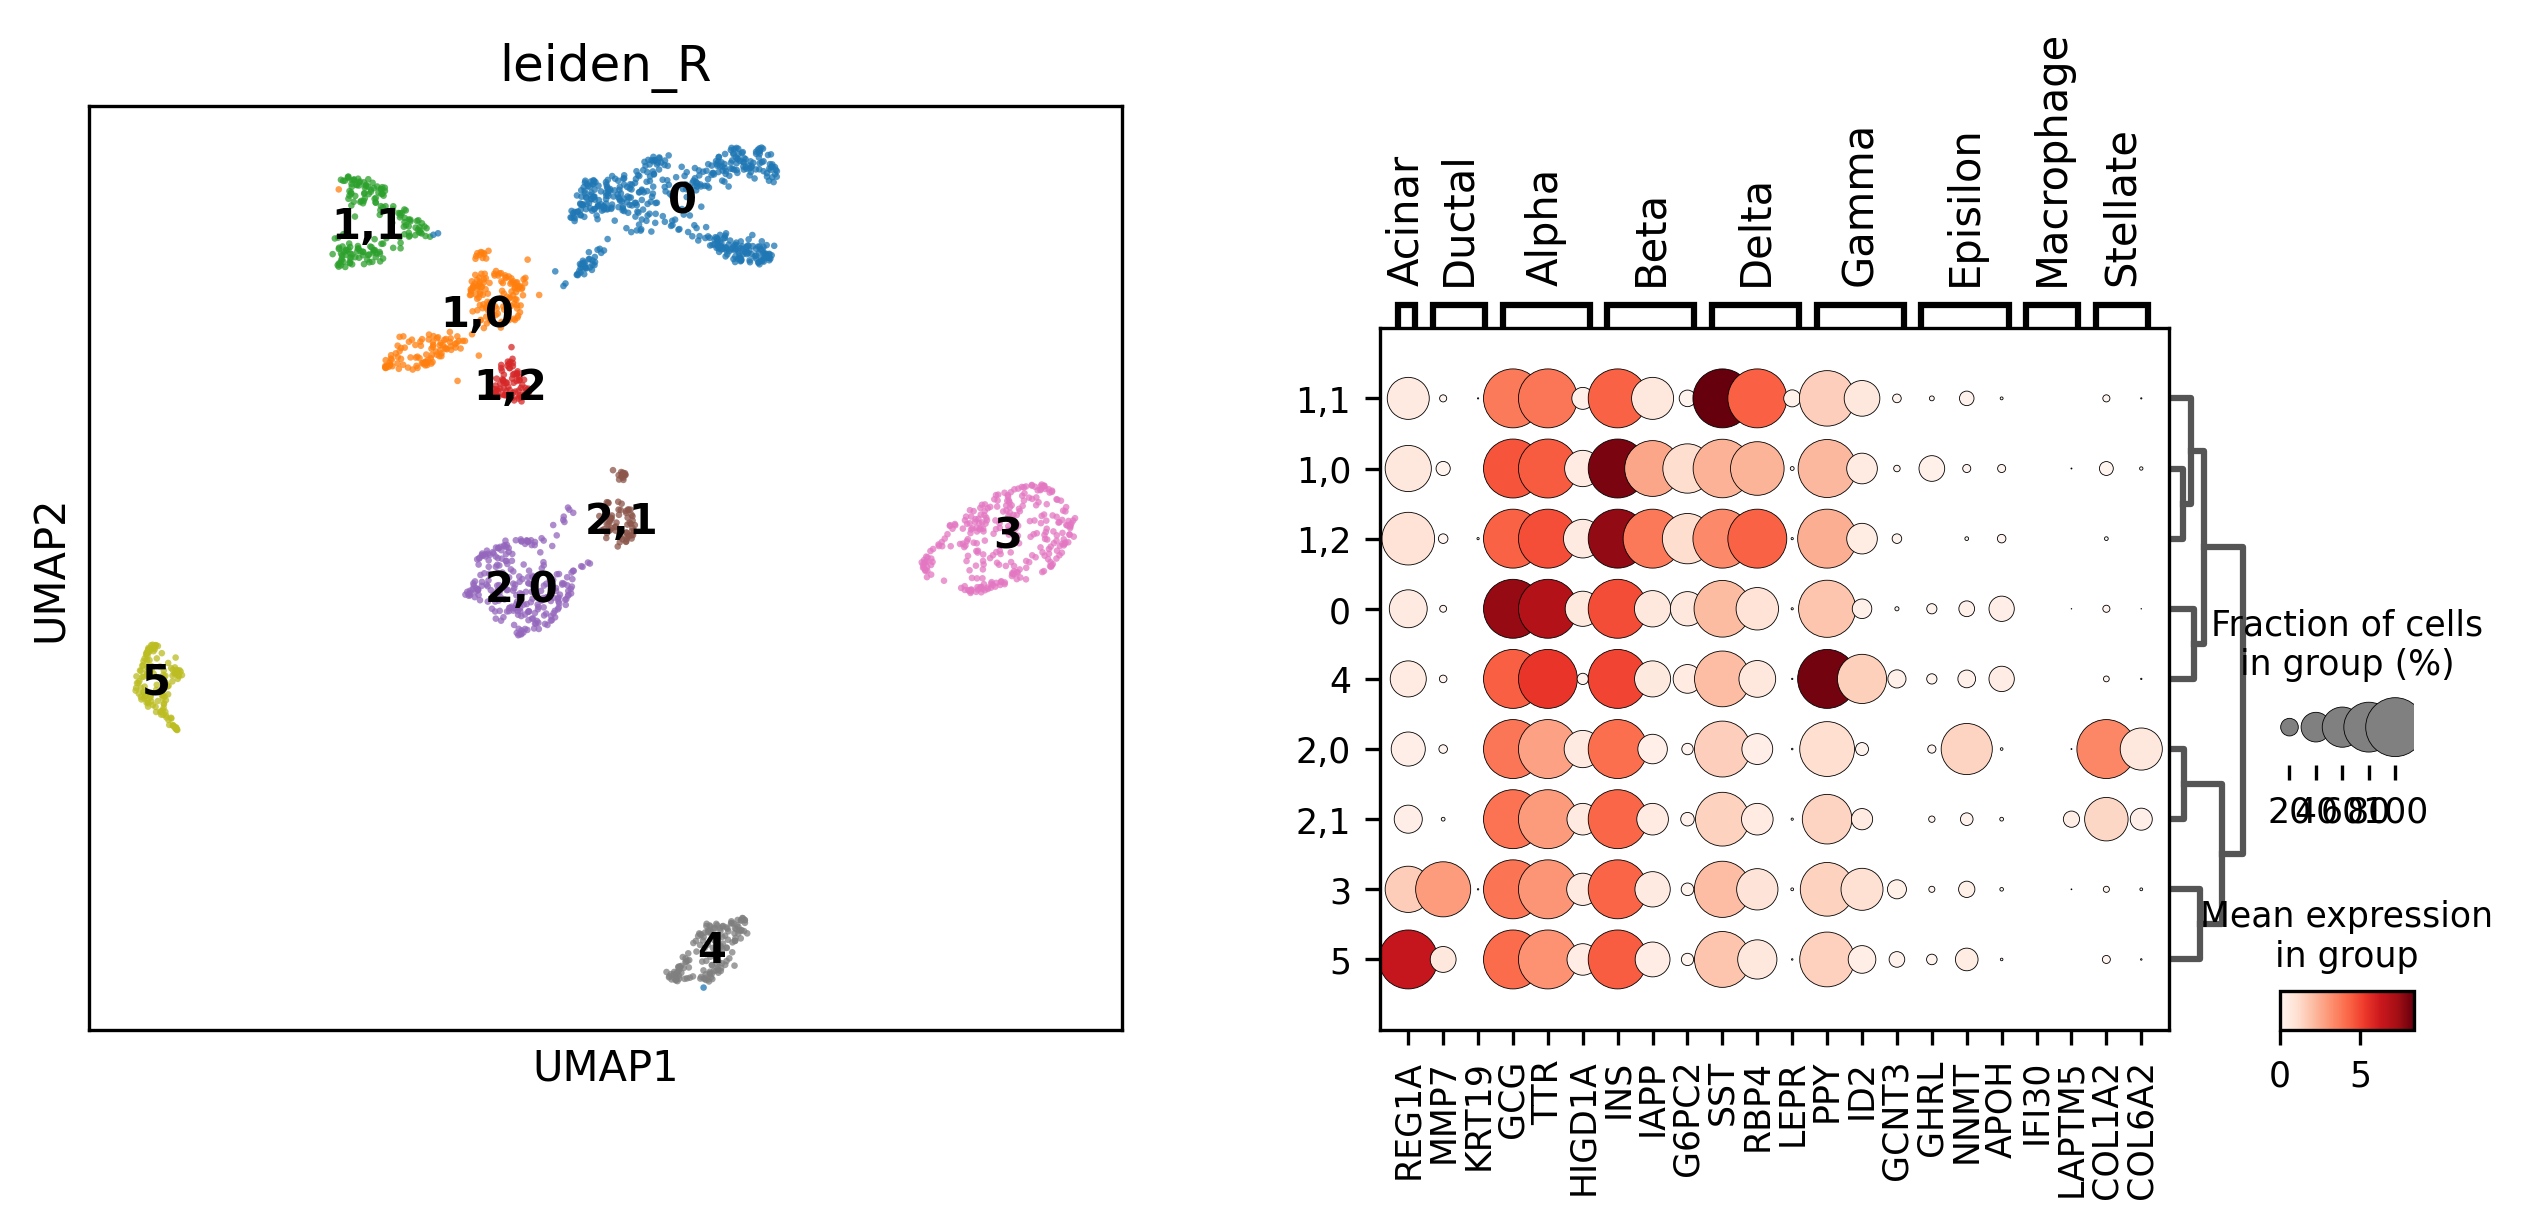

In [107]:
sc.tl.leiden(adCluster1,.1, restrict_to=["leiden_R",["2"]])
sc.tl.dendrogram(adCluster1, "leiden_R")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'wspace':0.25})
ax1_dict = sc.pl.umap(adCluster1,color=['leiden_R'], alpha=.75, s=10, legend_loc='on data', ax=ax1, show=False)
ax2_dict = sc.pl.dotplot(adCluster1, marker_genes_dict, 'leiden_R', dendrogram=True,ax=ax2, show=False)
plt.show()

2,0 seems to be Epsilon while 2,1 seems to be Stellate with perhaps some macrophage expression.

| cluster | markers  of          | cell type       |
|---------|----------------------|-----------------|
| 4       | Gamma                | Gamma           |
| 1,0/1,2 | Beta                 | Beta            |
| 1,1     | Delta                | Delta           |
| 3       | Ductal               | Ductal          |
| 5       | Acinar               | Acinar          |
| 0       | Alpha                | Alpha           |
| 2,0     | Epsilon              | Epsilon         |
| 2,1     | Stellate             | Stellate        |

In [108]:
adAnn = adCluster1.copy()

### Annotating

In [109]:
cell_dict = {
    'Alpha': ['0'],
    'Beta': ['1,0', '1,2'],
    'Delta': ['1,1'],
    'Ductal': ['3'],
    'Stellate': ['2,1'],
    'Epsilon': ['2,0'],
    'Acinar': ['5'],
    'Gamma': ['4'],
}

adAnn.obs['cell_type_pred'] = np.nan

for i in cell_dict.keys():
    ind = pd.Series(adAnn.obs.leiden_R).isin(cell_dict[i])
    adAnn.obs.loc[ind,'cell_type_pred'] = i

adAnn.obs.loc[adAnn.obs['cell_type_pred'].isna(), 'cell_type_pred'] = 'Macrophage'

adAnn.obs['cell_type_pred'] = adAnn.obs['cell_type_pred'].astype("category")
adAnn.obs['cell_type_pred']

AAACATTGATCACG-1      Acinar
AAACGCTGGCTGTA-1    Stellate
AAACGGCTTCGTTT-1       Gamma
AAAGGCCTATAAGG-1      Ductal
AAATCTGATTTGGG-1     Epsilon
                      ...   
TTGAGGACAGTCAC-1      Ductal
TTGGAGTGCATGAC-1        Beta
TTTAGGCTTTTCAC-1       Delta
TTTATCCTGTTGCA-1       Alpha
TTTCAGTGTTTCGT-1        Beta
Name: cell_type_pred, Length: 1861, dtype: category
Categories (8, object): ['Acinar', 'Alpha', 'Beta', 'Delta', 'Ductal', 'Epsilon', 'Gamma', 'Stellate']

### Performance Metrics

In [110]:
labels = np.unique(adAnn.obs['cell_type'])
scores_bkknn = f1_score(adAnn.obs['cell_type'], adAnn.obs['cell_type_pred'], labels = labels, average = None)
for i, label in enumerate(labels):
  print(f'{label}: {scores_bkknn[i]:.02f}')

Acinar: 0.96
Alpha: 0.75
Beta: 0.84
Delta: 0.72
Ductal: 0.98
Epsilon: 0.00
Gamma: 0.60
Macrophage: 0.00
Stellate: 0.26


## PySingleCellNet

In [111]:
adTrain3 = adTrain.copy()
adValid3 = adValid.copy()

In [112]:
pySCN.limit_anndata_to_common_genes([adTrain3, adValid3])

In [113]:
adLearn, adHeldOut = pySCN.splitCommonAnnData(adTrain3, ncells=50,dLevel="cell_type")

Macrophage : 
110
Ductal : 
110
Stellate : 
110
Gamma : 
110
Alpha : 
110
Epsilon : 
110
Acinar : 
110
Delta : 
110
Beta : 
110


In [114]:
clf = pySCN.scn_train(adLearn, dLevel = 'cell_type', nTopGenes = 200, nTopGenePairs = 200, nRand = 100, nTrees = 1000, stratify=False, propOther=0.1)

HVG
Matrix normalized
There are  1193  classification genes

Acinar
Alpha
Beta
Delta
Ductal
Epsilon
Gamma
Macrophage
Stellate
There are 3226 top gene pairs

Finished pair transforming the data



0.9754098360655739
0.8426229508196722
0.8761329305135952
0.8411552346570398
0.98989898989899
0.5408805031446542
0.8078817733990148
0.9032258064516129
0.9672977624784854


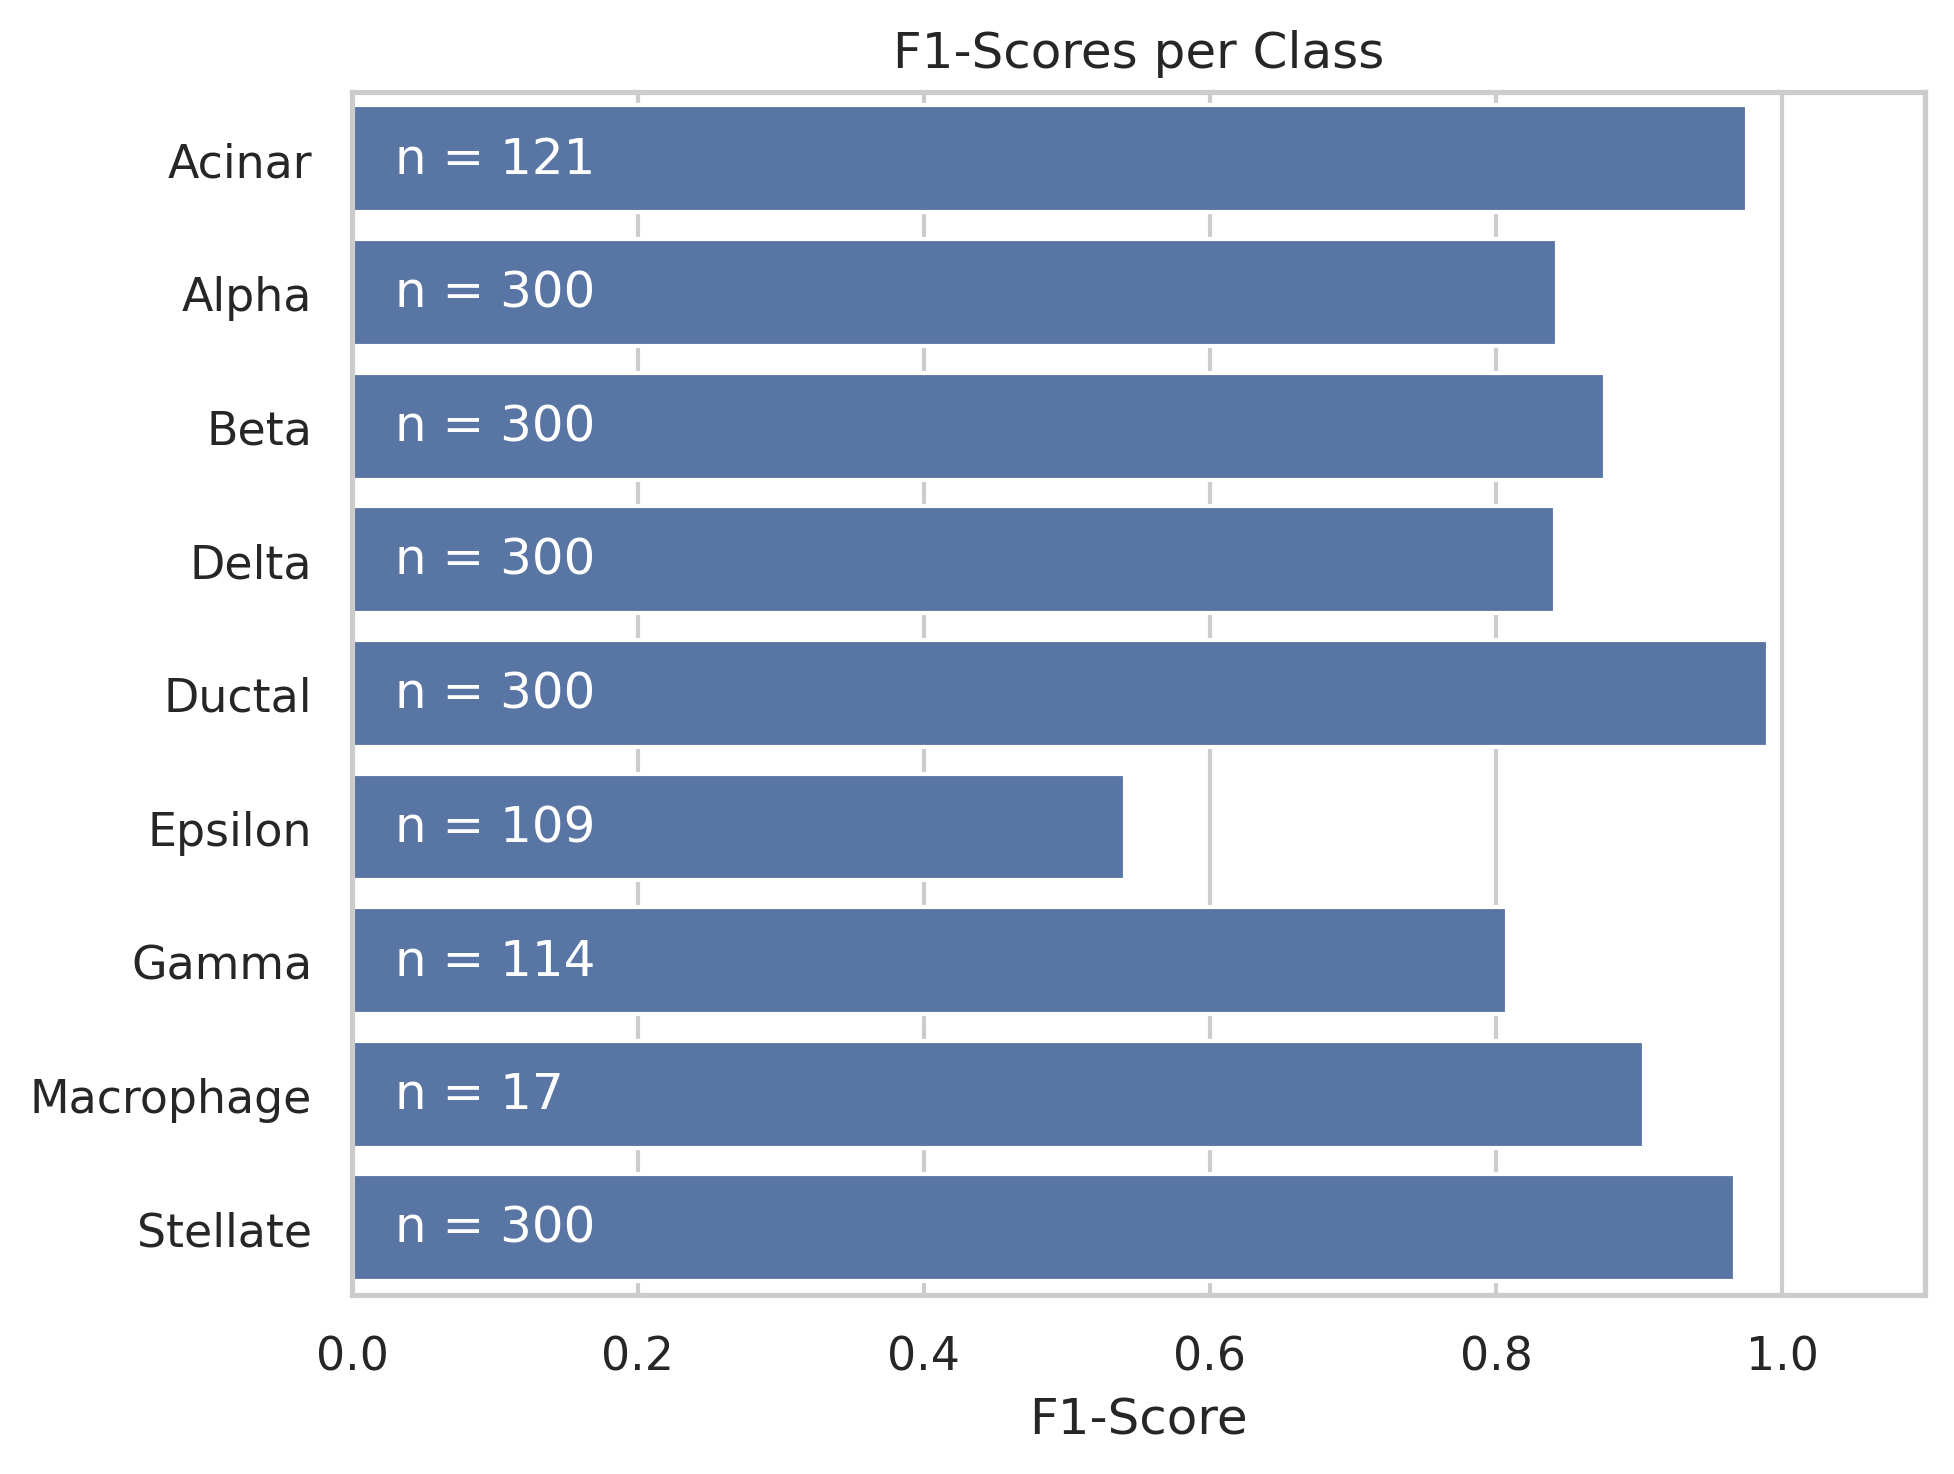

In [115]:
adValid_norm = pySCN.norm_hvg_scale_pca(adValid3)
pySCN.scn_classify(adValid_norm, clf, nrand = 0)
pySCN.barplot_classifier_f1(adValid_norm, ground_truth="cell_type", class_prediction="SCN_class")

## F1 Score Comparison

| Cell Type   |Cluster-Then-Annotate| BKKNN | PySingleCellNet |
|-------------|---------------------|-------|-----------------|
| Acinar      | 0.96                | 0.96  | 0.98            |
| Alpha       | 0.78                | 0.75  | 0.84            |
| Beta        | 0.88                | 0.84  | 0.88            |
| Delta       | 0.72                | 0.72  | 0.84            |
| Ductal      | 0.98                | 0.98  | 0.99            |
| Epsilon     | 0.00                | 0.00  | 0.54            |
| Gamma       | 0.60                | 0.60  | 0.81            |
| Macrophage  | 0.97                | 0.00  | 0.90            |
| Stellate    | 0.28                | 0.26. | 0.97            |




With the exception of macrophage predictions, PySingleCellNet outperformed all other methods as expected. Between Cluster-Then-Annotate and BKKNN, BKKNN unexpectedly performed the same or worse for multiple cell types. Most notably, macrophages seem to have been entirely excluded, which is highly odd.

# Question 2A

Here are some strategies to distinguish true hybrids from doublets:

1. **Characterization of Hybrid Signature**: An ideal method would first aim to define the signature features of hybrid cells. This could involve analyzing known hybrid cell lines or artificially generated hybrids to identify unique molecular markers or gene expression patterns characteristic of hybrid states.

2. **Integration of Multi-Omics Data**: Utilizing multiple omics modalities such as transcriptomics, epigenomics, and proteomics could provide a more comprehensive view of cellular states. By examining different layers of cellular information simultaneously, the method may better discriminate between true hybrids and other cell types.

3. **Machine Learning Approaches**: Employing advanced machine learning algorithms trained on known hybrid and non-hybrid cell populations could help in distinguishing between the two. These algorithms could utilize a combination of features such as gene expression profiles, protein markers, and morphological characteristics to classify cells accurately.

4. **Single-Cell Imaging Techniques**: Incorporating imaging techniques alongside single-cell sequencing can provide spatial context and additional morphological information. True hybrids may exhibit distinct morphological features not present in doublets, aiding in their identification.

5. **Functional Assays**: Performing functional assays on suspected hybrid cells could provide valuable insights into their behavior and characteristics. This could include assessing their differentiation potential, response to stimuli, or other functional properties unique to hybrids.

6. **Statistical Analysis of Single-Cell Data**: Developing statistical methods tailored to identify hybrids based on deviations from expected gene expression patterns or cellular heterogeneity may also be effective. This could involve clustering algorithms designed to detect outlier cells with mixed expression profiles.

7. **Validation with Experimental Controls**: Validating the classification of suspected hybrid cells using experimental controls, such as lineage tracing or cell mixing experiments, can confirm their hybrid nature and help refine the cell typing method.

By integrating multiple complementary approaches and continuously refining the criteria for distinguishing hybrids from other cell types, an ideal cell-typing method could effectively address the challenge of characterizing these complex cellular states.

# Question 2B

## Hybrid Generation

In [116]:
def generate_synthetic_hybrids(adata):
    """
    Generate synthetic hybrid populations by summing or averaging the expression profiles of cells of different identities.

    Parameters:
        adata (AnnData): An AnnData object containing expression data.

    Returns:
        AnnData: An AnnData object containing synthetic hybrid populations.
    """
    res = adata.copy()
    cell_types = list(np.unique(adata.obs['cell_type']))

    for i in range(3, 6):
      for j in range(9):
        # Randomly select cells of the current cell type
        A_cells = adata[adata.obs['cell_type'] == cell_types[j]]
        selected_A_cells = A_cells[np.random.choice(len(A_cells), 30)]

        for k in range(j + 1, 9):
          # Randomly select cells of another cell type not the same as the current
          B_cells = adata[adata.obs['cell_type'] == cell_types[k]]
          selected_B_cells = B_cells[np.random.choice(len(B_cells), 30)]

          # Combine their expressions as a weighted average
          hybrid_cells = selected_A_cells.copy()
          hybrid_cells.obs['cell_type'] = cell_types[j] + '-' + cell_types[k]
          hybrid_cells.obs.iloc[:, 1:-2] = 1/i * np.asarray(selected_A_cells.obs.iloc[:, 1:-2]) + (1-1/i) * np.asarray(selected_B_cells.obs.iloc[:, 1:-2])

          # Update
          res = ad.concat([res, hybrid_cells])

    return res

In [117]:
adHybrid = ad.concat([adValid, generate_synthetic_hybrids(adValid)])
adHybrid.obs

sample_id  n_genes_by_counts  total_counts  \
AAACATTGATCACG-1   Donor_1             1454.0        8158.0   
AAACGCTGGCTGTA-1   Donor_1             1639.0        7323.0   
AAACGGCTTCGTTT-1   Donor_1             1351.0        8005.0   
AAAGGCCTATAAGG-1   Donor_1             1387.0        5239.0   
AAATCTGATTTGGG-1   Donor_1             2163.0       10863.0   
...                    ...                ...           ...   
AAACGCTGGCTGTA-1   Donor_1             1703.0        6828.6   
TCTAAGCTAGCTAC-1   Donor_1             1612.0        8032.4   
TAGTTAGAAACGTC-1   Donor_1             2612.6       22726.2   
CTAGGTGATCCTCG-1   Donor_4             2422.2       11977.4   
GAGGCAGAGGTGAG-1   Donor_1             2190.8        9854.6   

                  total_counts_ribo  pct_counts_ribo  total_counts_mt  \
AAACATTGATCACG-1             1872.0        22.946800            179.0   
AAACGCTGGCTGTA-1             1423.0        19.431927            189.0   
AAACGGCTTCGTTT-1             1012.0        12.642099            283.0   
AAAGGCCTATAAGG-1              975.0        18.610422            349.0   
AAATCTGATTTGGG-1             2936.0        27.027523            225.0   
...                             ...              ...              ...   
AAACGCTGGCTGTA-1             1443.8        21.174976            186.6   
TCTAAGCTAGCTAC-1             2258.8        26.522298            223.6   
TAGTTAGAAACGTC-1             5188.6        21.954509            816.4   
CTAGGTGATCCTCG-1             1859.0        15.777617            346.6   
GAGGCAGAGGTGAG-1             2118.4        21.001450            195.4   

                  pct_counts_mt  n_genes  n_counts            cell_type  \
AAACATTGATCACG-1       2.194165   1355.0    6107.0               Acinar   
AAACGCTGGCTGTA-1       2.580909   1541.0    5711.0           Macrophage   
AAACGGCTTCGTTT-1       3.535290   1254.0    6710.0                Gamma   
AAAGGCCTATAAGG-1       6.661577   1291.0    3915.0               Ductal   
AAATCTGATTTGGG-1       2.071251   2061.0    7702.0             Stellate   
...                         ...      ...       ...                  ...   
AAACGCTGGCTGTA-1       2.735421   1605.0    5198.2  Macrophage-Stellate   
TCTAAGCTAGCTAC-1       2.921742   1512.4    5550.0  Macrophage-Stellate   
TAGTTAGAAACGTC-1       3.415300   2509.4   16721.2  Macrophage-Stellate   
CTAGGTGATCCTCG-1       2.833122   2319.2    9771.8  Macrophage-Stellate   
GAGGCAGAGGTGAG-1       2.078972   2091.2    7540.8  Macrophage-Stellate   

                            cellid  
AAACATTGATCACG-1  AAACATTGATCACG-1  
AAACGCTGGCTGTA-1  AAACGCTGGCTGTA-1  
AAACGGCTTCGTTT-1  AAACGGCTTCGTTT-1  
AAAGGCCTATAAGG-1  AAAGGCCTATAAGG-1  
AAATCTGATTTGGG-1  AAATCTGATTTGGG-1  
...                            ...  
AAACGCTGGCTGTA-1  AAACGCTGGCTGTA-1  
TCTAAGCTAGCTAC-1  TCTAAGCTAGCTAC-1  
TAGTTAGAAACGTC-1  TAGTTAGAAACGTC-1  
CTAGGTGATCCTCG-1  CTAGGTGATCCTCG-1  
GAGGCAGAGGTGAG-1  GAGGCAGAGGTGAG-1  

[6962 rows x 11 columns]

In [132]:
adHybrid.obs['cell_type'] = adHybrid.obs['cell_type'].astype("category")

## Pipeline Comparison

### Cluster-Then-Annotate

<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

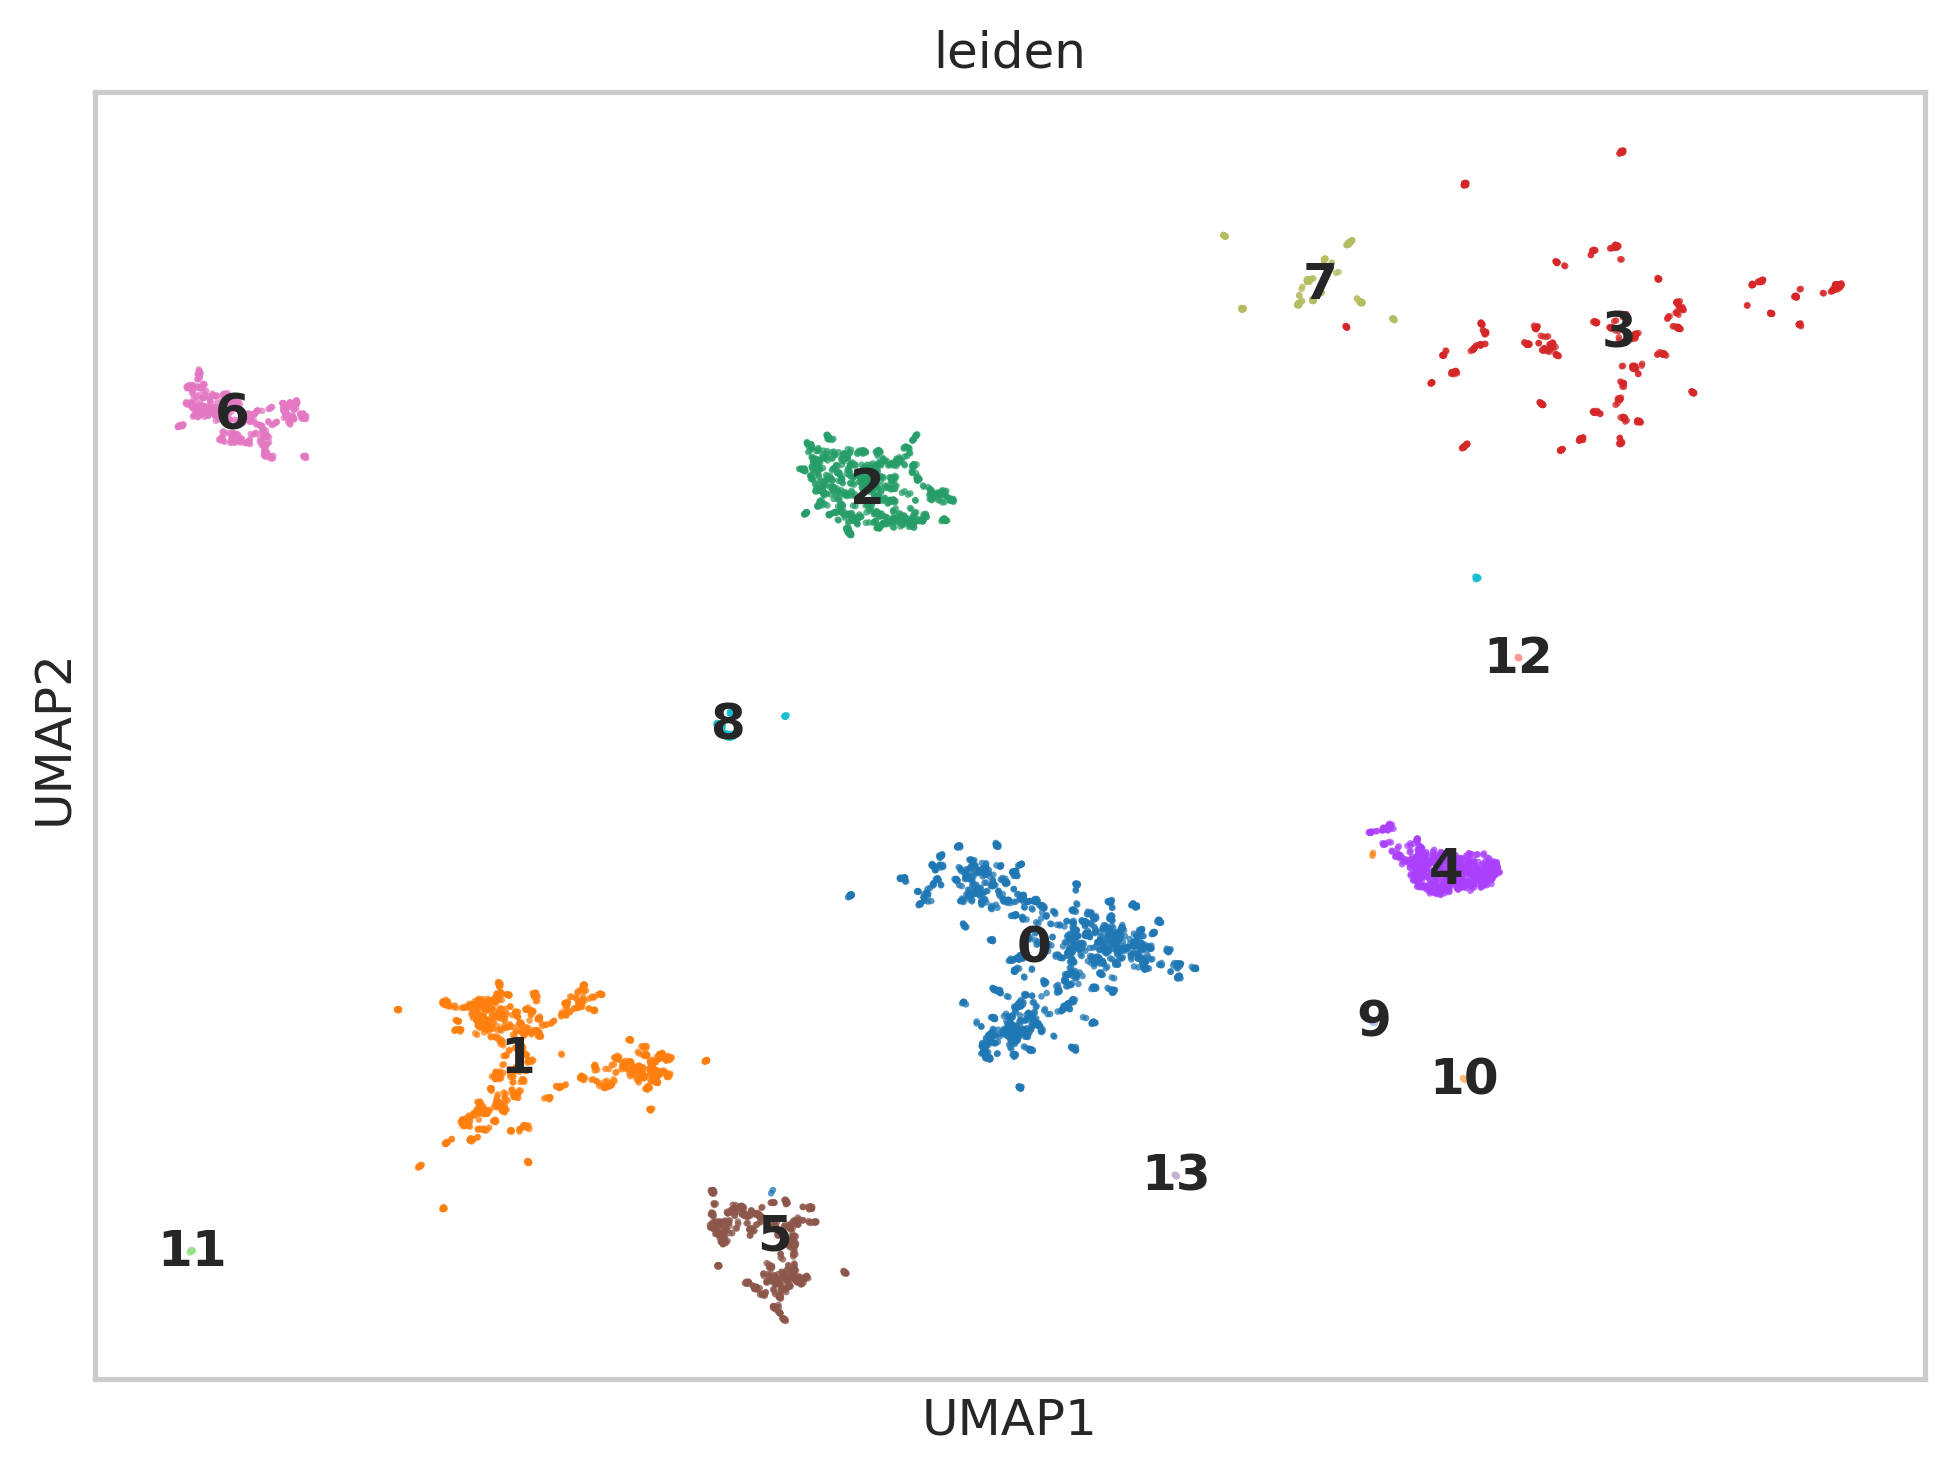

In [141]:
adValid4 = adHybrid.copy()
sc.pp.normalize_total(adValid4, target_sum=1e4)
sc.pp.log1p(adValid4)
sc.pp.highly_variable_genes(adValid4, min_mean=0.0125, max_mean=6, min_disp=0.25)
sc.tl.pca(adValid4, use_highly_variable=True)

adPrep = adValid4.copy()
sc.pp.neighbors(adPrep, n_neighbors=1000, n_pcs=10)
sc.tl.leiden(adPrep,.1)
sc.tl.paga(adPrep)
sc.pl.paga(adPrep, plot=False)
sc.tl.umap(adPrep, 0.25, init_pos='paga')
sc.pl.umap(adPrep,color=['leiden'], alpha=.75, s=10, legend_loc='on data', show=False)

categories: 0, 1, 2, etc.
var_group_labels: Acinar, Ductal, Alpha, etc.


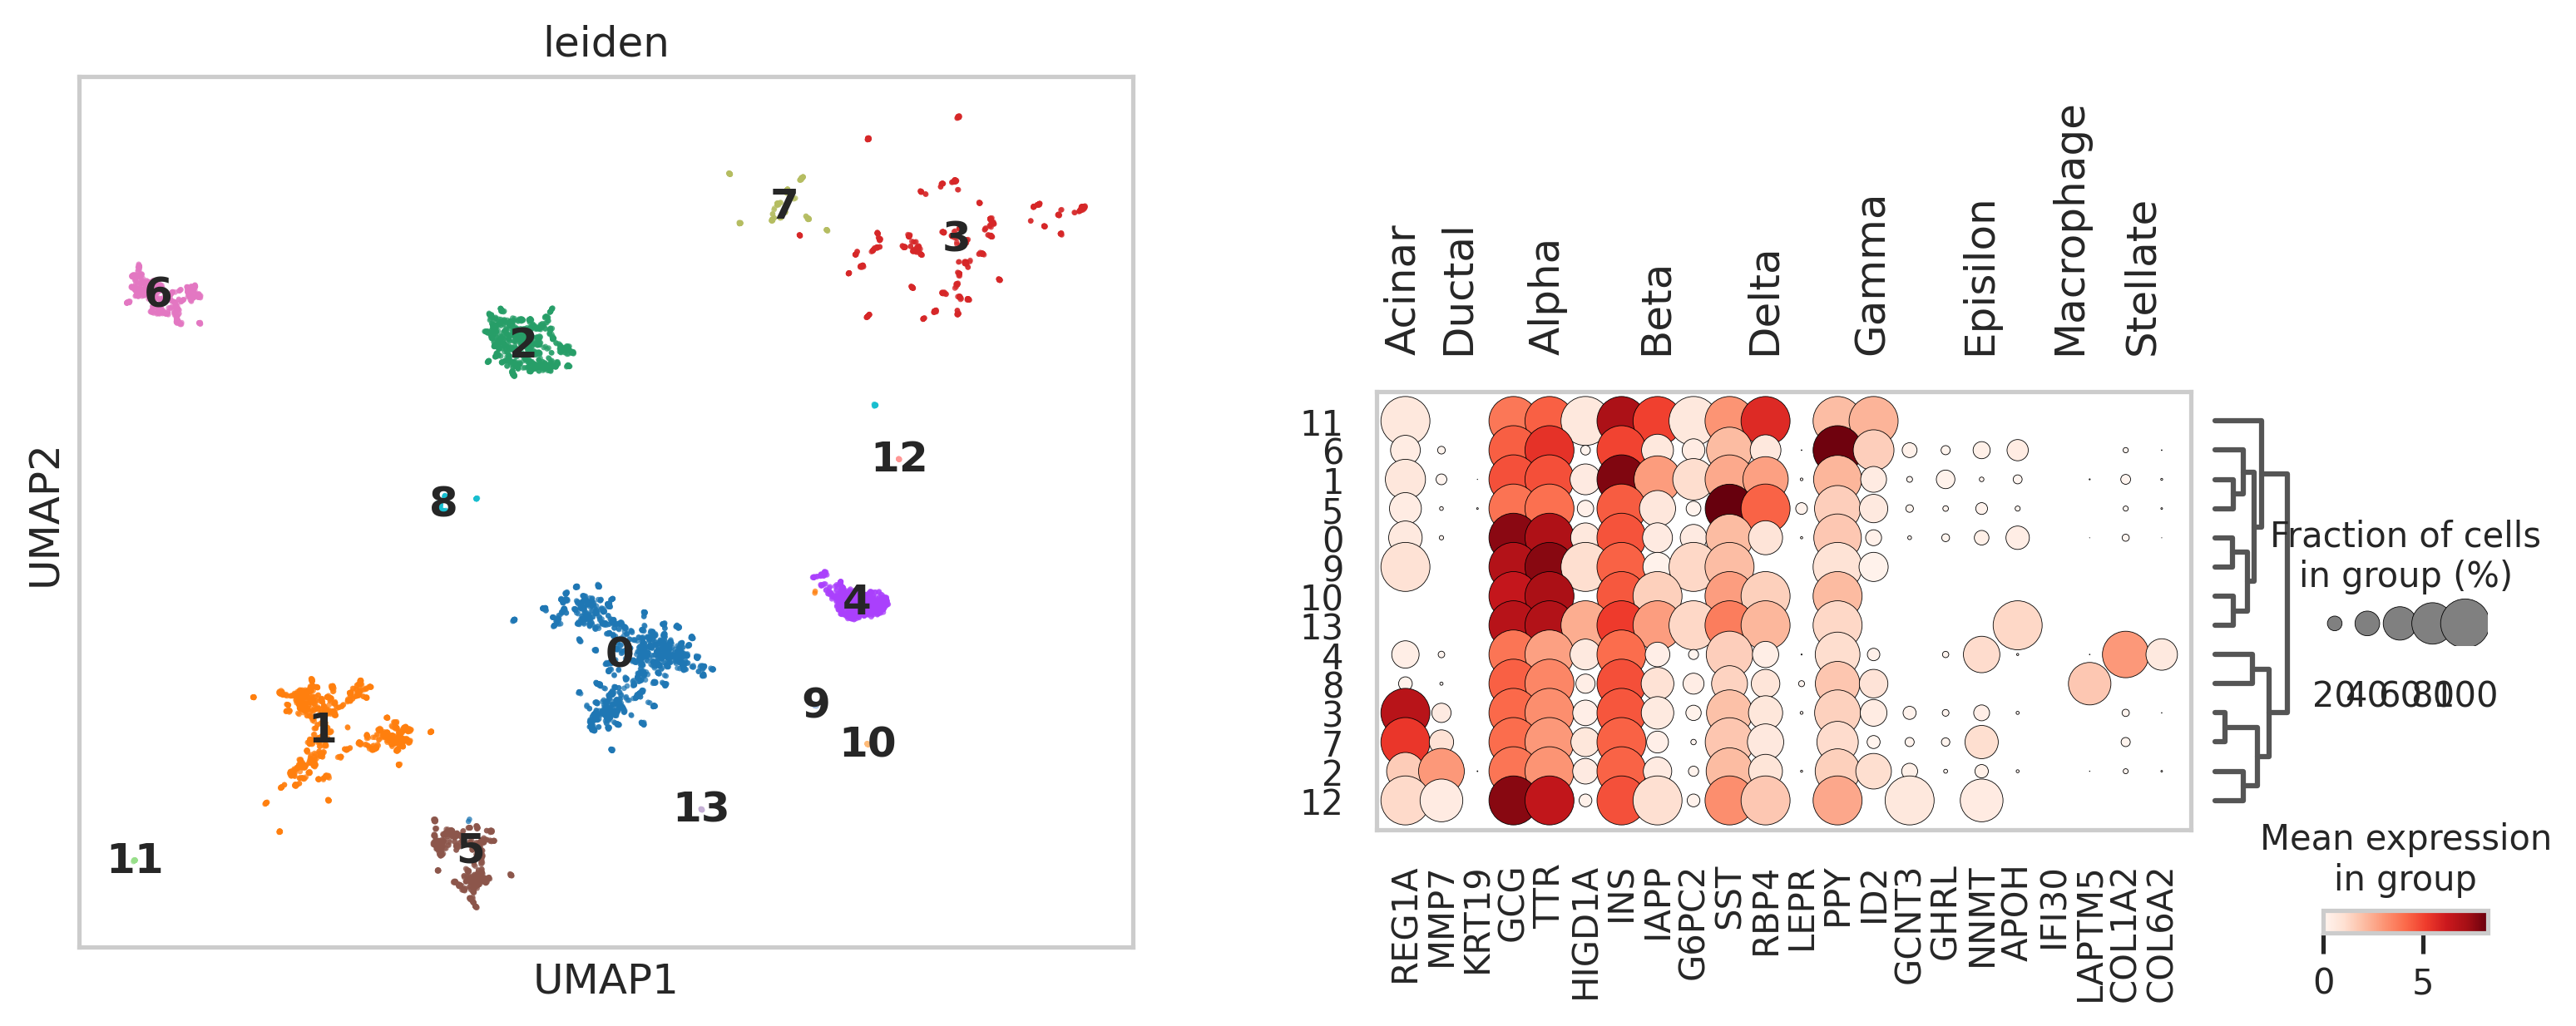

In [142]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'wspace':0.25})
ax1_dict = sc.pl.umap(adPrep,color=['leiden'], alpha=.75, s=10, legend_loc='on data', ax=ax1, show=False)
ax2_dict = sc.pl.dotplot(adPrep, marker_genes_dict, 'leiden', dendrogram=True,ax=ax2, show=False)
plt.show()

| cluster | markers  of          | cell type       |
|---------|----------------------|-----------------|
|   6     |  Gamma               | Gamma           |
|   1/11  | Beta                 | Beta            |
|   5     | Delta                | Delta           |
| 2       | Ductal               | Ductal          |
| 3/7       | Acinar               | Acinar          |
|   8     | Macrophage           | Macrophage      |
|0/9/10/12       | Alpha                | Alpha           |
|   13     |  Epsilon     | Epsilon             |
| 4        | Stellate | Stellate|

In [145]:
adAnn = adPrep.copy()
cell_dict = {
    'Alpha': ['0', '9', '10', '12'],
    'Beta': ['1', '11'],
    'Delta': ['5'],
    'Ductal': ['2'],
    'Stellate': ['4'],
    'Epsilon': ['13'],
    'Acinar': ['3', '7'],
    'Gamma': ['4'],
    'Macrophage': ['8']
}

adAnn.obs['cell_type_pred'] = np.nan

for i in cell_dict.keys():
    ind = pd.Series(adAnn.obs.leiden).isin(cell_dict[i])
    adAnn.obs.loc[ind,'cell_type_pred'] = i

adAnn.obs.loc[adAnn.obs['cell_type_pred'].isna(), 'cell_type_pred'] = 'Macrophage'

adAnn.obs['cell_type_pred'] = adAnn.obs['cell_type_pred'].astype("category")
adAnn.obs['cell_type_pred']

AAACATTGATCACG-1        Acinar
AAACGCTGGCTGTA-1    Macrophage
AAACGGCTTCGTTT-1    Macrophage
AAAGGCCTATAAGG-1        Ductal
AAATCTGATTTGGG-1         Gamma
                       ...    
AAACGCTGGCTGTA-1    Macrophage
TCTAAGCTAGCTAC-1    Macrophage
TAGTTAGAAACGTC-1         Alpha
CTAGGTGATCCTCG-1    Macrophage
GAGGCAGAGGTGAG-1    Macrophage
Name: cell_type_pred, Length: 6962, dtype: category
Categories (8, object): ['Acinar', 'Alpha', 'Beta', 'Delta', 'Ductal', 'Epsilon', 'Gamma',
                         'Macrophage']

In [147]:
labels = np.unique(adValid.obs['cell_type'])
scores_bkknn = f1_score(adAnn.obs['cell_type'], adAnn.obs['cell_type_pred'], labels = labels, average = None)
for i, label in enumerate(labels):
  print(f'{label}: {scores_bkknn[i]:.02f}')

Acinar: 0.40
Alpha: 0.48
Beta: 0.60
Delta: 0.56
Ductal: 0.75
Epsilon: 0.02
Gamma: 0.00
Macrophage: 0.09
Stellate: 0.00


### BKKNN

<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

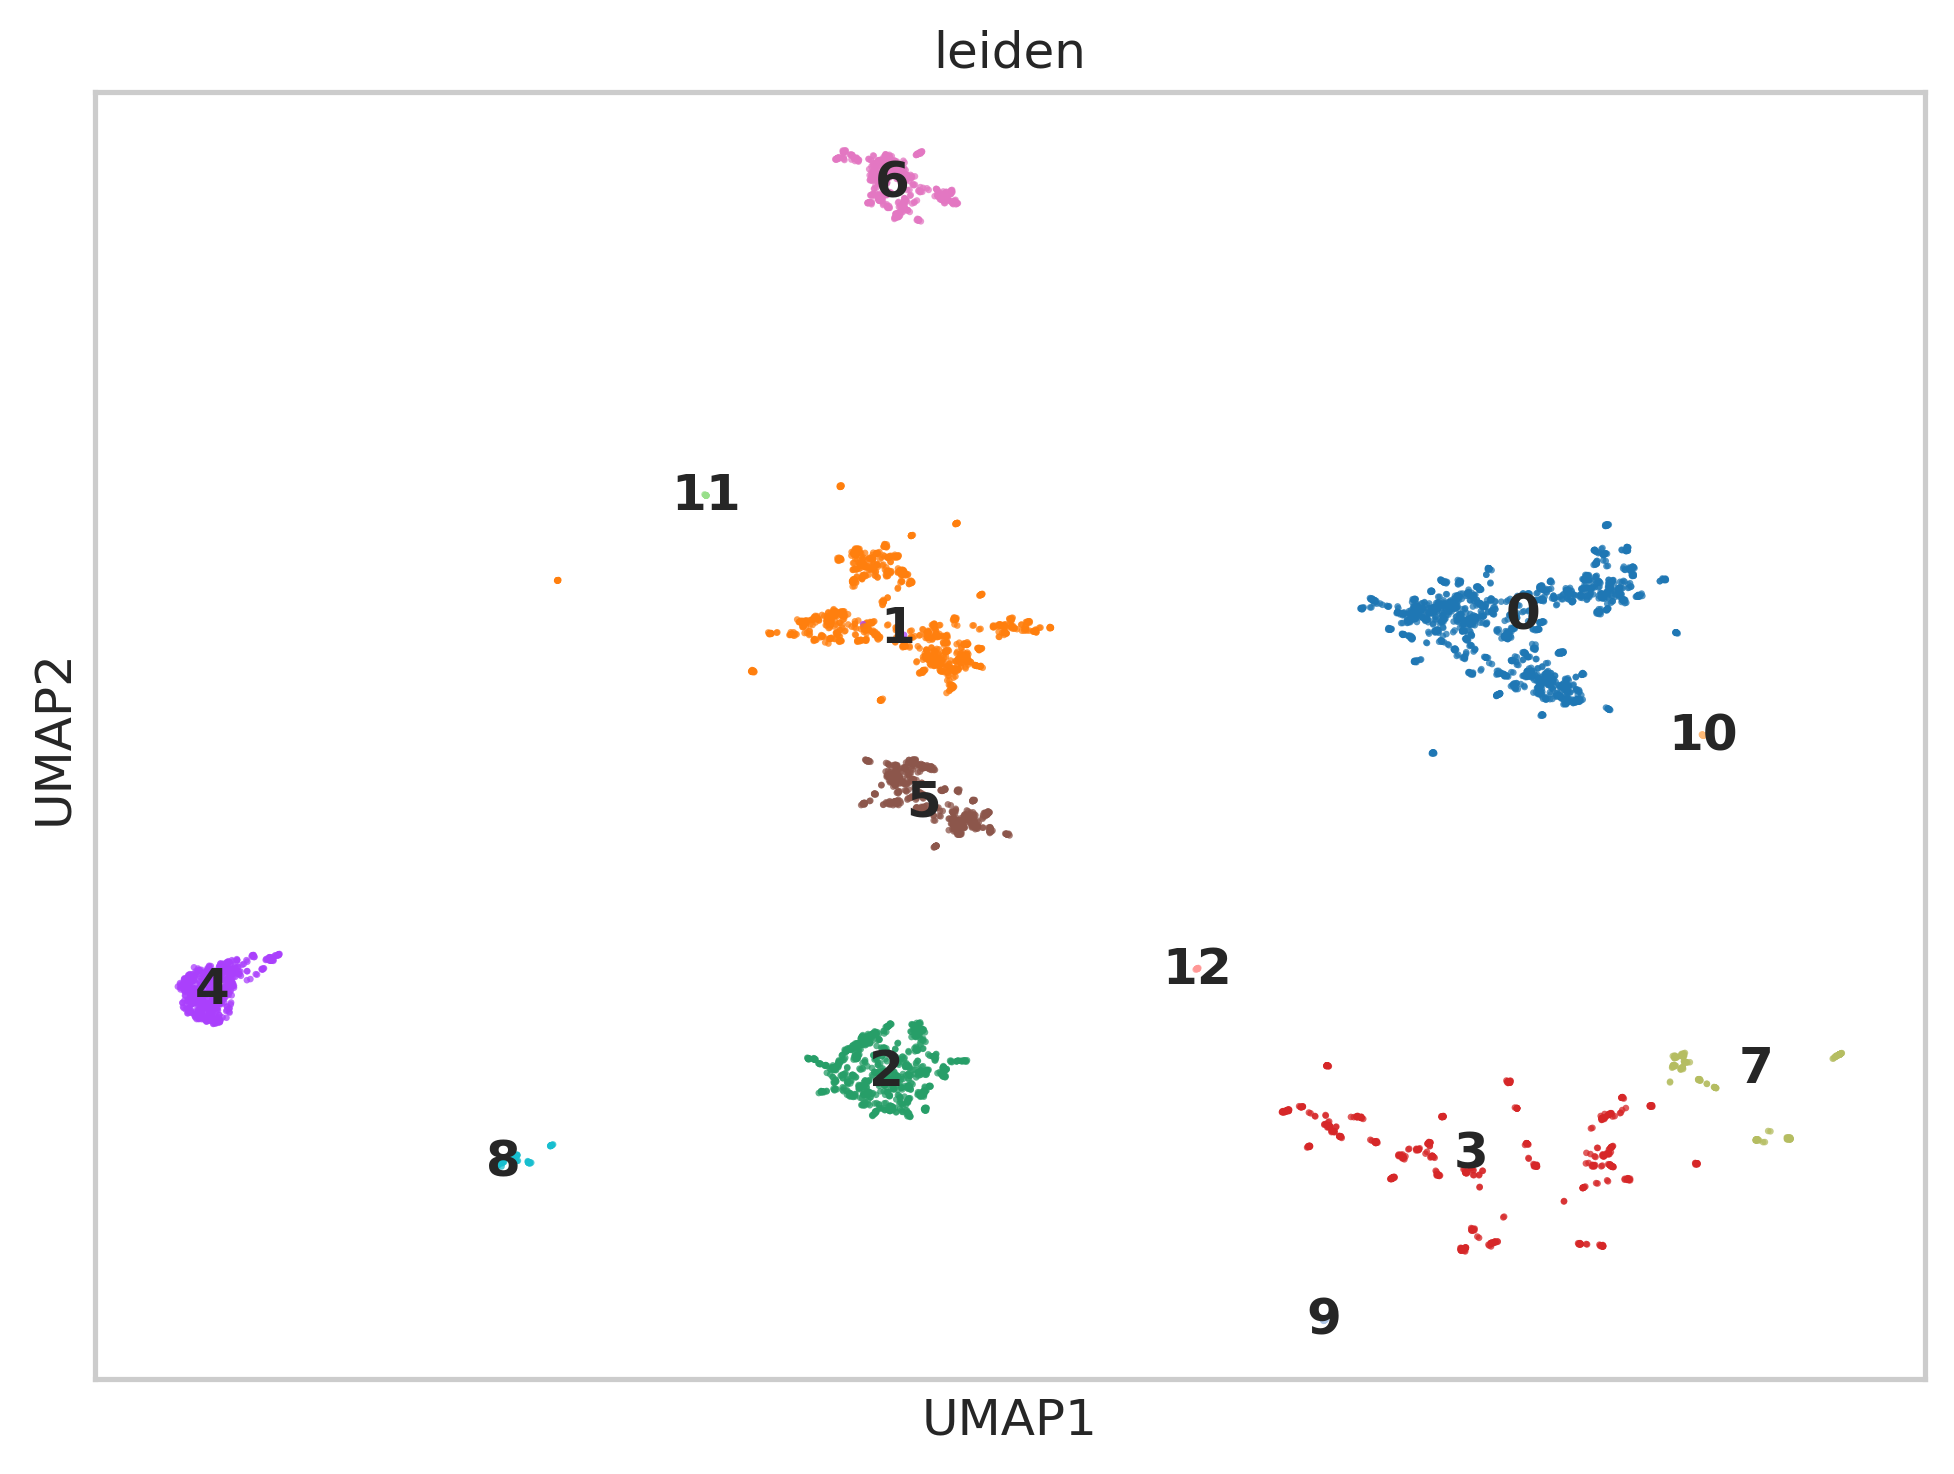

In [156]:
adValid5 = adHybrid.copy()
sc.pp.normalize_total(adValid5, target_sum=1e4)
sc.pp.log1p(adValid5)
sc.pp.highly_variable_genes(adValid5, min_mean=0.0125, max_mean=6, min_disp=0.25)
sc.tl.pca(adValid5, use_highly_variable=True)

adPrep = adValid5.copy()
sc.external.pp.bbknn(adPrep, batch_key = 'sample_id', neighbors_within_batch=500, n_pcs=10)
sc.tl.leiden(adPrep,.1)
sc.tl.paga(adPrep)
sc.pl.paga(adPrep, plot=False)
sc.tl.umap(adPrep, 0.25, init_pos='paga')
sc.pl.umap(adPrep,color=['leiden'], alpha=.75, s=10, legend_loc='on data', show=False)

categories: 0, 1, 2, etc.
var_group_labels: Acinar, Ductal, Alpha, etc.


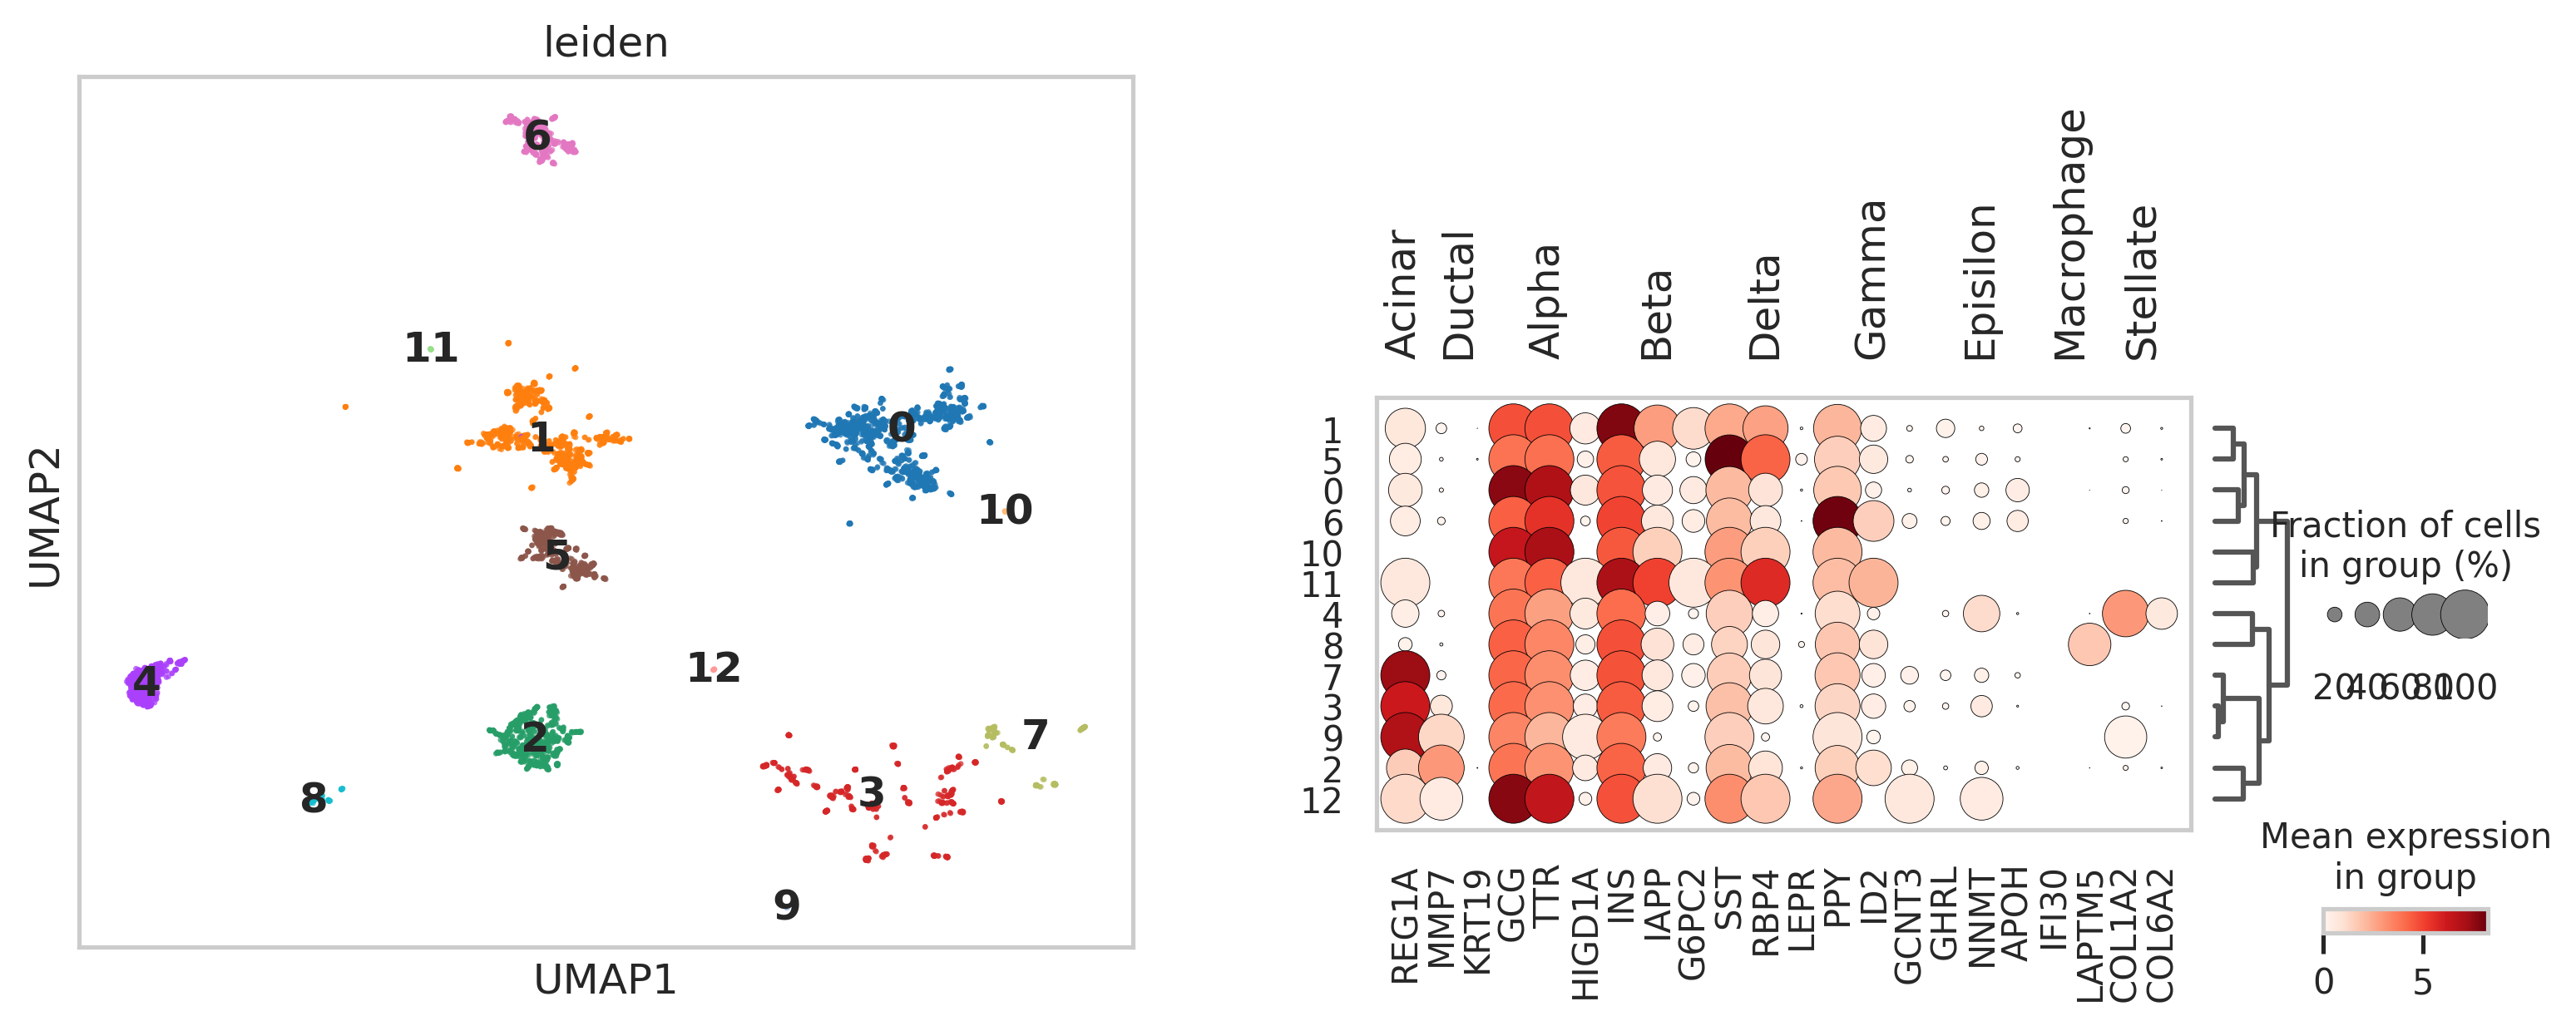

In [157]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'wspace':0.25})
ax1_dict = sc.pl.umap(adPrep,color=['leiden'], alpha=.75, s=10, legend_loc='on data', ax=ax1, show=False)
ax2_dict = sc.pl.dotplot(adPrep, marker_genes_dict, 'leiden', dendrogram=True,ax=ax2, show=False)
plt.show()

| cluster | markers  of          | cell type       |
|---------|----------------------|-----------------|
|   6     |  Gamma               | Gamma           |
|   1/11  | Beta                 | Beta            |
|   5     | Delta                | Delta           |
| 2       | Ductal               | Ductal          |
| 3/7/9       | Acinar               | Acinar          |
|   8     | Macrophage           | Macrophage      |
|0/10       | Alpha                | Alpha           |
|   12     |  Epsilon     | Epsilon             |
| 4        | Stellate | Stellate|

In [158]:
adAnn = adPrep.copy()
cell_dict = {
    'Alpha': ['0', '10'],
    'Beta': ['1', '11'],
    'Delta': ['5'],
    'Ductal': ['2'],
    'Stellate': ['4'],
    'Epsilon': ['12'],
    'Acinar': ['3', '7', '9'],
    'Gamma': ['6'],
    'Macrophage': ['8']
}

adAnn.obs['cell_type_pred'] = np.nan

for i in cell_dict.keys():
    ind = pd.Series(adAnn.obs.leiden).isin(cell_dict[i])
    adAnn.obs.loc[ind,'cell_type_pred'] = i

adAnn.obs.loc[adAnn.obs['cell_type_pred'].isna(), 'cell_type_pred'] = 'Macrophage'

adAnn.obs['cell_type_pred'] = adAnn.obs['cell_type_pred'].astype("category")
adAnn.obs['cell_type_pred']

AAACATTGATCACG-1        Acinar
AAACGCTGGCTGTA-1    Macrophage
AAACGGCTTCGTTT-1         Gamma
AAAGGCCTATAAGG-1        Ductal
AAATCTGATTTGGG-1      Stellate
                       ...    
AAACGCTGGCTGTA-1    Macrophage
TCTAAGCTAGCTAC-1    Macrophage
TAGTTAGAAACGTC-1         Alpha
CTAGGTGATCCTCG-1    Macrophage
GAGGCAGAGGTGAG-1    Macrophage
Name: cell_type_pred, Length: 6962, dtype: category
Categories (9, object): ['Acinar', 'Alpha', 'Beta', 'Delta', ..., 'Epsilon', 'Gamma', 'Macrophage',
                         'Stellate']

In [159]:
labels = np.unique(adValid.obs['cell_type'])
scores_bkknn = f1_score(adAnn.obs['cell_type'], adAnn.obs['cell_type_pred'], labels = labels, average = None)
for i, label in enumerate(labels):
  print(f'{label}: {scores_bkknn[i]:.02f}')

Acinar: 0.40
Alpha: 0.48
Beta: 0.60
Delta: 0.56
Ductal: 0.75
Epsilon: 0.00
Gamma: 0.42
Macrophage: 0.43
Stellate: 0.96


### PySingleCellNet

In [133]:
adTrain6 = adTrain.copy()
adValid6 = adHybrid.copy()

In [136]:
pySCN.limit_anndata_to_common_genes([adTrain6, adValid6])

In [137]:
adLearn, adHeldOut = pySCN.splitCommonAnnData(adTrain6, ncells=50,dLevel="cell_type")

Macrophage : 
110
Ductal : 
110
Stellate : 
110
Gamma : 
110
Alpha : 
110
Epsilon : 
110
Acinar : 
110
Delta : 
110
Beta : 
110


In [138]:
clf = pySCN.scn_train(adLearn, dLevel = 'cell_type', nTopGenes = 200, nTopGenePairs = 200, nRand = 100, nTrees = 1000, stratify=False, propOther=0.1)

HVG
Matrix normalized
There are  1190  classification genes

Acinar
Alpha
Beta
Delta
Ductal
Epsilon
Gamma
Macrophage
Stellate
There are 3222 top gene pairs

Finished pair transforming the data



0.398671096345515
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5124760076775432
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.6496350364963503
0.0
0.0
0.0
0.0
0.0
0.0
0.6416184971098267
0.0
0.0
0.0
0.0
0.0
0.7584415584415585
0.0
0.0
0.0
0.0
0.28571428571428575
0.0
0.0
0.0
0.5310924369747899
0.0
0.0
0.42953020134228187
0.0
0.9551724137931035


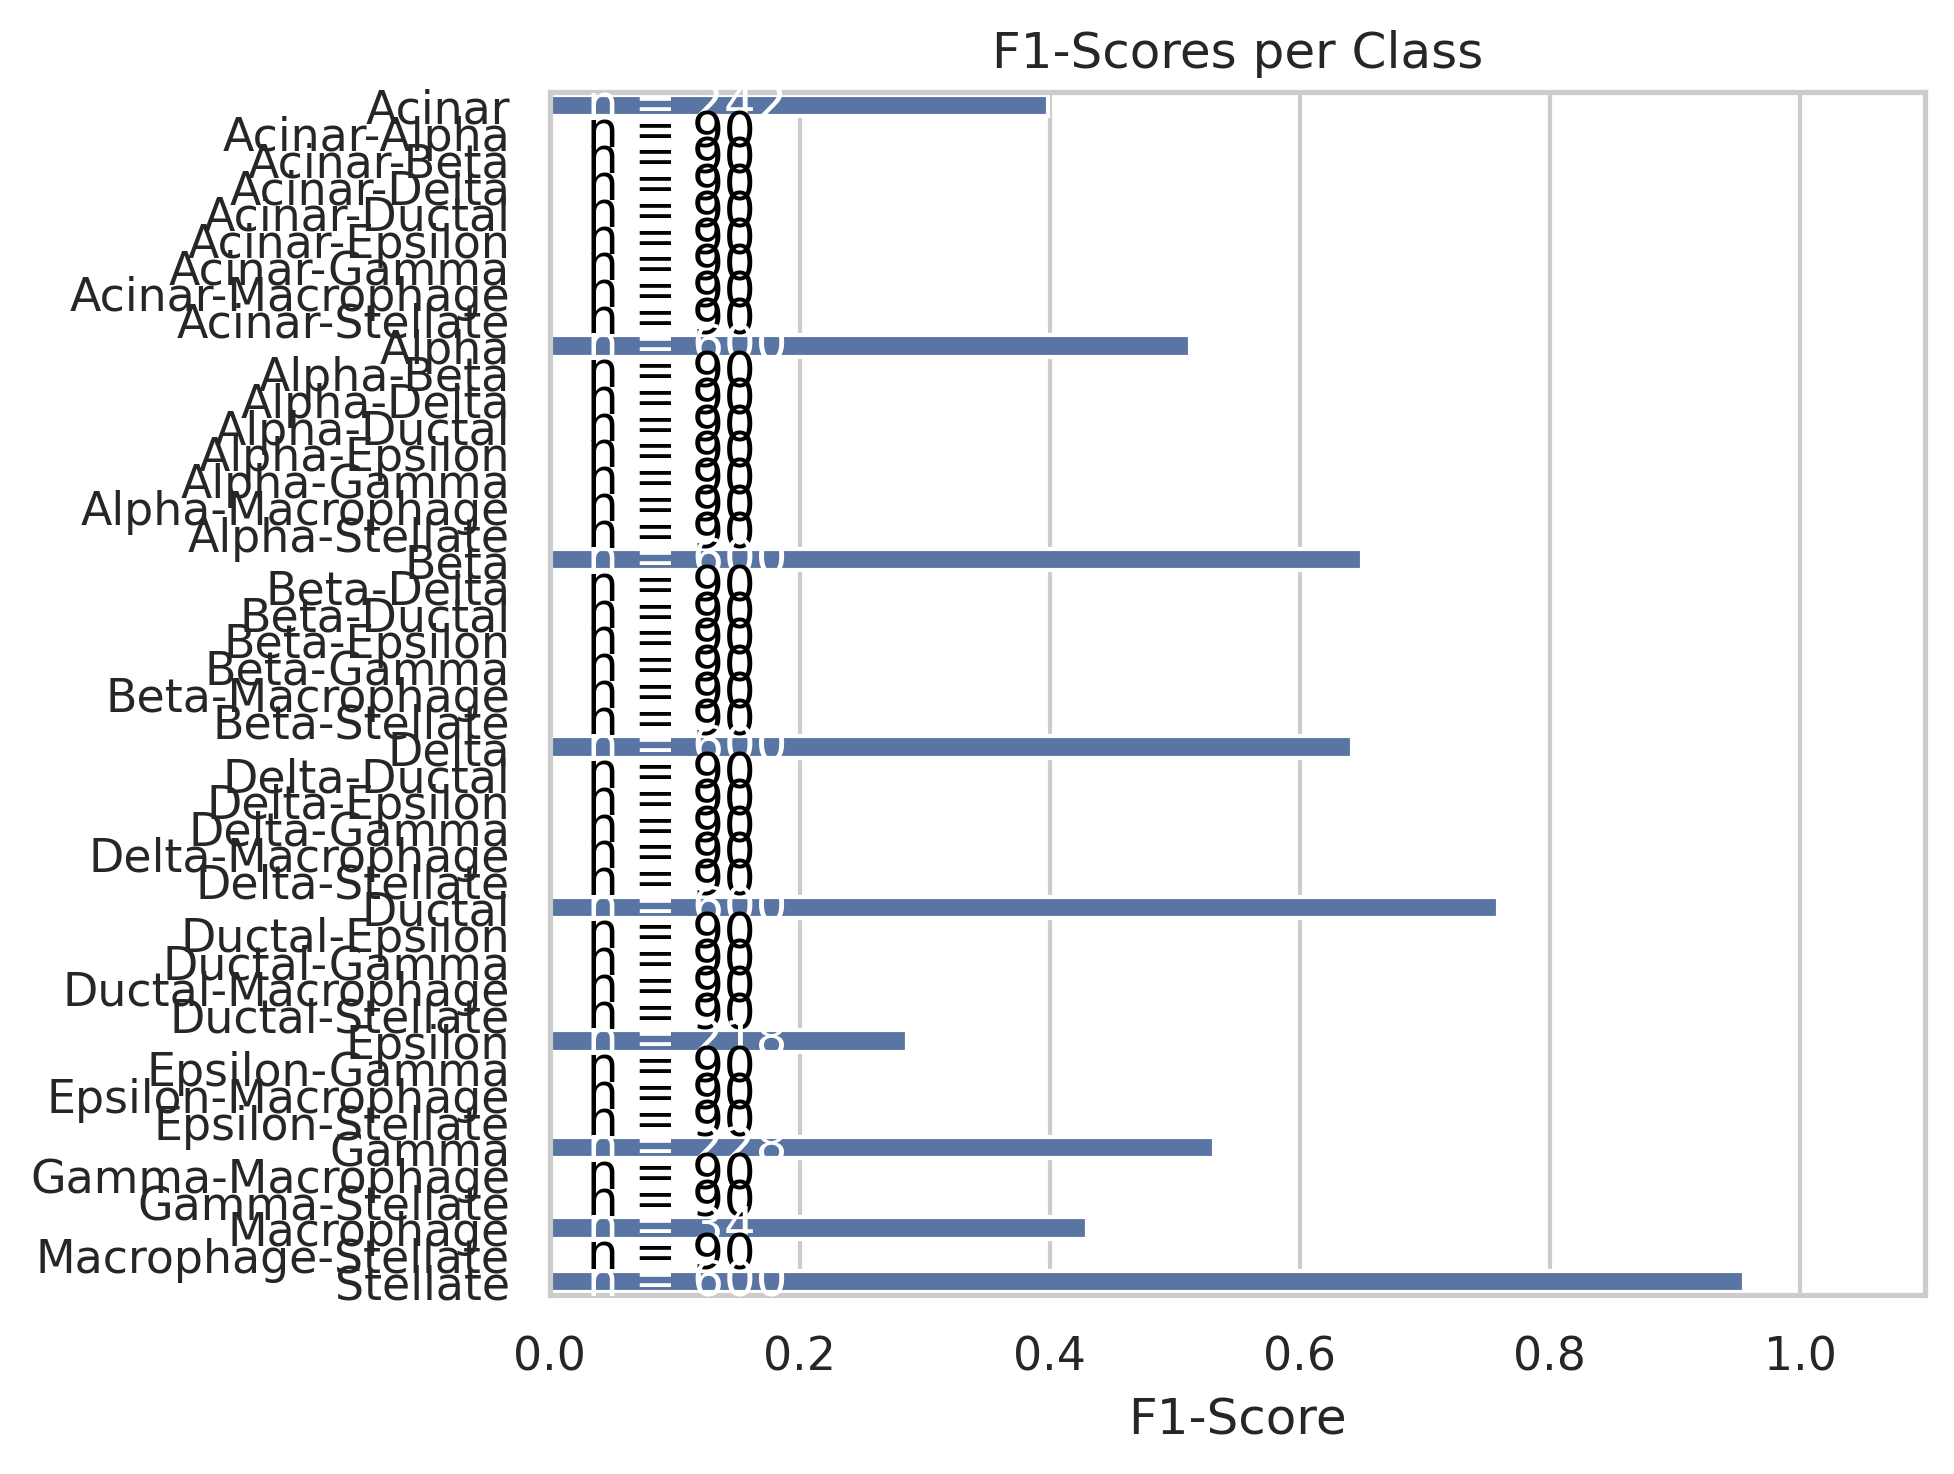

In [139]:
adValid_norm = pySCN.norm_hvg_scale_pca(adValid6)
pySCN.scn_classify(adValid_norm, clf, nrand = 0)
pySCN.barplot_classifier_f1(adValid_norm, ground_truth="cell_type", class_prediction="SCN_class")

### Results

| Cell Type   |Cluster-Then-Annotate| BKKNN | PySingleCellNet |
|-------------|---------------------|-------|-----------------|
| Acinar      | 0.40                | 0.40  | 0.40            |
| Alpha       | 0.48                | 0.48  | 0.51            |
| Beta        | 0.60                | 0.60  | 0.65            |
| Delta       | 0.56                | 0.56  | 0.64            |
| Ductal      | 0.75                | 0.75  | 0.76            |
| Epsilon     | 0.02                | 0.00  | 0.29            |
| Gamma       | 0.00                | 0.42  | 0.53            |
| Macrophage  | 0.09                | 0.43  | 0.43            |
| Stellate    | 0.00                | 0.96  | 0.96            |


### Discussion

- **Please characterize the types of failures that are common and unique to each method
and discuss how these failures could impact the analysis of real engineered cells.**

Across the board, each method experienced a dramatic decrease in f1-scores compared to their performance on the non-hybrid dataset. In this instance, their performances lined up with expectations (i.e. PySingleCellNet > BKKNN > Cluster-Then-Annotate) as can be seen in how they performed in identifying Gamma cells. Overall, the presence of hybrid identities make cell identification very difficult and frustrating, especially if one is doing so by any of the clustering methods.

- **If you had to select one cell typing method, which would it be and why?**

Due to ease of use as well as overall higher performance across every cell type, I would choose the PySingleCellNet method.
